# Assignment - 2
# Prakhar Jain
# 2022121008

Data preparation and rules
Please use the images of the MNIST hand-written digits recognition dataset. You may use torchvision.datasets
library to obtain the images and splits. You should have 60,000 training images and 10,000 test images. Use test
images only to evaluate your model performance.

## Q1: SIFT-BoVW-SVM [4 points]

1. [2 points] Implement the SIFT detector and descriptor. Compute cluster centers for the Bag-of-Visual-Words
approach. Represent the images as histograms (of visual words) and train a linear SVM model for 10-way
classification.

    `Note` 1: You may want to use libraries such as cv2 (OpenCV) and sklearn (Sci-kit learn) for doing this question.
https://scikit-learn.org/stable/modules/svm.html#multi-class-classification may be useful for the
SVM.

    `Note` 2: Seed random numbers for reproducibility (running the notebook again should give you the same results!).


---

In [1]:
DATASET_PATH = "MNIST"

DEBUG = False

In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans #, MiniBatchKMeans
from sklearn import svm
# from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import wandb
from tqdm.notebook import tqdm

In [3]:
class SIFT_SVM_Classifier:
    def __init__(self, dataset_path, n_clusters=8, sift_features=0, svm_c=1.0, svm_kernel='linear'):
        """
        Initialize the classifier with the dataset path, number of clusters for KMeans,
        number of SIFT features to extract, and SVM parameters.
        """
        self.dataset_path = dataset_path
        self.n_clusters = n_clusters
        self.sift_features = sift_features  # New SIFT parameter
        self.svm_c = svm_c  # New SVM parameter for regularization strength
        self.svm_kernel = svm_kernel  # New SVM parameter for kernel type
        self.kmeans = None
        self.clf = svm.SVC(kernel=self.svm_kernel, C=self.svm_c, decision_function_shape='ovr', random_state=42)
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
        ])

    def load_data(self):
        """
        Load the MNIST dataset using torchvision's datasets module.
        Returns two DataLoader objects for the training and testing datasets.
        """
        torch.manual_seed(42)
        train_dataset = datasets.MNIST(self.dataset_path, train=True, download=True, transform=self.transform)
        test_dataset = datasets.MNIST(self.dataset_path, train=False, download=True, transform=self.transform)

        # print the no of images in the dataset
        # print('Number of images in dataset:', len(train_dataset))

        train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

        return train_dataloader, test_dataloader

    def extract_sift_features(self, image):
        """
        Use OpenCV's SIFT_create method to extract SIFT features from an image.
        """
        sift = cv2.SIFT_create(nfeatures=self.sift_features)
        keypoints, descriptors = sift.detectAndCompute(image, None)
        return descriptors

    def compute_kmeans(self, sift_features):
        """
        Compute the KMeans clustering on the SIFT features extracted from the images.
        """
        # self.kmeans = MiniBatchKMeans(n_clusters=self.n_clusters, random_state=42)
        self.kmeans = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=42)
        self.kmeans.fit(np.concatenate(sift_features))

    def image_to_histogram(self, descriptors):
        """
        Convert the SIFT descriptors of an image into a histogram of visual words
        by assigning each descriptor to the closest cluster center.
        """
        histogram = np.zeros(self.n_clusters)
        if descriptors is not None:
            predicted_labels = self.kmeans.predict(descriptors)
            for label in predicted_labels:
                histogram[label] += 1
        return histogram

    def prepare_features(self, dataloader, isTrain=False):
        """
        Prepare the histograms and labels for all images in a DataLoader.
        """
        sift_features = []
        labels = []
        for images, label in dataloader:

            image = images.squeeze().numpy() * 255

            image = image.astype(np.uint8)

            descriptors = self.extract_sift_features(image)
            if descriptors is not None:
                sift_features.append(descriptors)
                labels.append(label.item())
        if isTrain:
            self.compute_kmeans(sift_features)

        histograms = [self.image_to_histogram(feat) for feat in sift_features]
        return histograms, labels

    def train(self, X_train, y_train):
        """
        Train the SVM classifier on the training data.
        """
        self.clf.fit(X_train, y_train)

    def test(self, X_test, y_test):
        """
        Test the SVM classifier on the testing data and return the accuracy score.
        """
        return self.clf.score(X_test, y_test)

    def run(self):
        """
        Orchestrates the entire process: load the data, prepare the features,
        train the classifier, test it, and print the accuracy.
        """
        train_dataloader, test_dataloader = self.load_data()

        X_train, y_train = self.prepare_features(train_dataloader, isTrain=True)

        X_test, y_test = self.prepare_features(test_dataloader)

        self.train(X_train, y_train)

        accuracy = self.test(X_test, y_test)

        # print('Accuracy:', accuracy)
        return accuracy


---

2. [1 point] Keeping everything else constant, plot how classification accuracy changes as you sweep across 6 different
values for the number of clusters. Please decide what numbers are meaningful for this question. Explain the
trends in classification accuracy that you observe.

    `Note` 1: It is recommended to try hyperparameters in logarithmic steps such as 2x or 3x multiples. An example
of 2x multiples is: 1, 2, 5, 10, 20, ... An example of 3x multiples is: 1, 3, 10, 30, 100, ...

Running with 5 clusters
Accuracy with 5 clusters: 0.3330269607843137
Running with 10 clusters
Accuracy with 10 clusters: 0.44873366013071897
Running with 20 clusters
Accuracy with 20 clusters: 0.5318627450980392
Running with 40 clusters
Accuracy with 40 clusters: 0.641748366013072
Running with 80 clusters
Accuracy with 80 clusters: 0.7316176470588235
Running with 160 clusters
Accuracy with 160 clusters: 0.795547385620915
Running with 320 clusters
Accuracy with 320 clusters: 0.8291462418300654


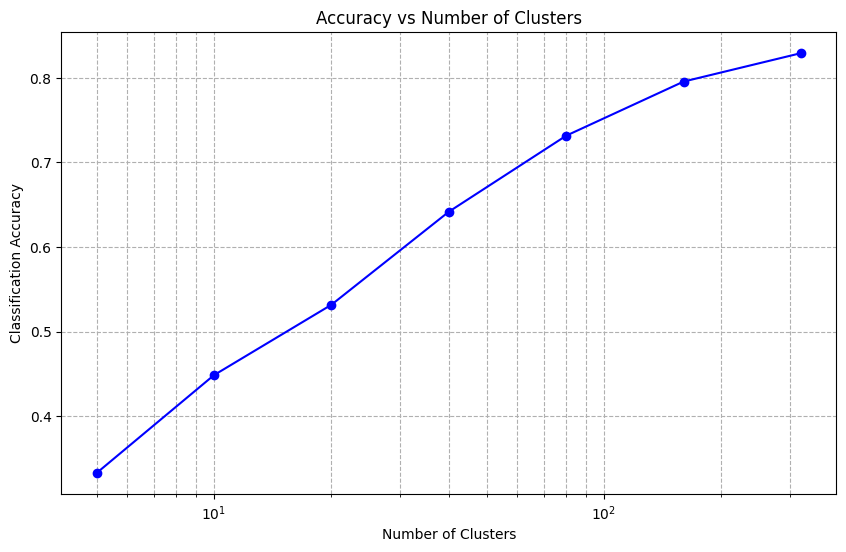

Best accuracy: (320, 0.8291462418300654)


In [3]:
def experiment_with_clusters(dataset_path):
    np.random.seed(0)
    n_clusters_options = [5, 10, 20, 40, 80, 160, 320]
    accuracies = []

    for n_clusters in n_clusters_options:
        print(f"Running with {n_clusters} clusters")
        classifier = SIFT_SVM_Classifier(dataset_path, n_clusters=n_clusters)
        accuracy = classifier.run()
        accuracies.append((n_clusters, accuracy))
        print(f"Accuracy with {n_clusters} clusters: {accuracy}")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    clusters, accs = zip(*accuracies)
    plt.plot(clusters, accs, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Classification Accuracy')
    plt.title('Accuracy vs Number of Clusters')
    plt.xscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()

    return accuracies

accuracies = experiment_with_clusters(DATASET_PATH)

print("Best accuracy:", max(accuracies, key=lambda x: x[1]))

Increasing the `n_clusters` the accuracy increases as more clusters mean that the visual words in our Bag-of-Visual-Words (BoVW) model are more granular which leads to a more discriminative representation of the images. However, after a certain point, the accuracy starts to plateau as after a certain point additional clusters only capture noise that is not useful for classification.

---

3. [1 point] Show the results for 6 different hyperparameter settings. You may play with the SIFT detector or
descriptor and the linear SVM. Keep the number of clusters constant based on the answer to the previous
question. Explain the trends in classification accuracy that you observe.

Running with C=10.0, SIFT Features=10
Accuracy with C=10.0, SIFT Features=10: 0.7883986928104575
Running with C=10.0, SIFT Features=50
Accuracy with C=10.0, SIFT Features=50: 0.7981004901960784
Running with C=10.0, SIFT Features=100
Accuracy with C=10.0, SIFT Features=100: 0.797998366013072
Running with C=100.0, SIFT Features=10
Accuracy with C=100.0, SIFT Features=10: 0.7889093137254902
Running with C=100.0, SIFT Features=50
Accuracy with C=100.0, SIFT Features=50: 0.7973856209150327
Running with C=100.0, SIFT Features=100
Accuracy with C=100.0, SIFT Features=100: 0.7977941176470589


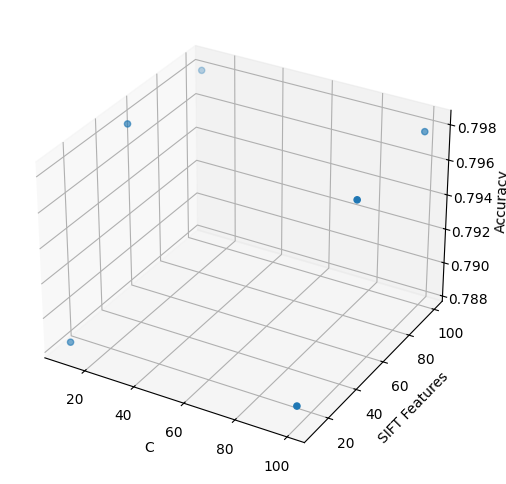

Best accuracy: (10.0, 50, 0.7981004901960784)


In [5]:
def experiment_with_hyperparameters(dataset_path):

    np.random.seed(0)

    n_clusters = 160

    accuracies = []

    for c in [10.0, 100.0]:
        for sift_features in [10, 50, 100]:
            print(f"Running with C={c}, SIFT Features={sift_features}")
            classifier = SIFT_SVM_Classifier(dataset_path, n_clusters=n_clusters, sift_features=sift_features, svm_c=c)
            accuracy = classifier.run()
            accuracies.append((c, sift_features, accuracy))
            print(f"Accuracy with C={c}, SIFT Features={sift_features}: {accuracy}")


    # Do a 3D plot of the results
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    cs, ss, accs = zip(*accuracies)
    ax.scatter(cs, ss, accs)
    ax.set_xlabel('C')
    ax.set_ylabel('SIFT Features')
    ax.set_zlabel('Accuracy')
    plt.show()

    return accuracies

accuracies = experiment_with_hyperparameters(DATASET_PATH)

print("Best accuracy:", max(accuracies, key=lambda x: x[2]))

It seems only `sift_features` affects the accuracy and not `C` in SVM.

---

# Q2: CNNs and Transformers [6 points]
1. [2.5 points] Set up a modular codebase for training a CNN (LeNet) on the task of handwritten digit recognition.
You should have clear functional separation between the data (dataset and dataloader), model (nn.Module),
and trainer (train/test epoch loops). Implement logging: using Weights & Biases is highly recommended,
alternatively, create your own plots using other plotting libraries. Log the training and evaluation losses and
accuracies at every epoch, show the plots for at least one training and evaluation run.

    `Note` 1: Seed random numbers for reproducibility (running the notebook again should give you the same results!).

In [ ]:
DATASET_PATH = "MNIST"

DEBUG = False

# seed for reproducibility

torch.manual_seed(42)
np.random.seed(42)

# DataLoaders

In [ ]:
def load_data(dataset_path, batch_size=128):
    transform = transforms.Compose([
                transforms.Resize((32,32)), # Resizing as MNIST is 28 * 28
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

    train_dataset = datasets.MNIST(dataset_path, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(dataset_path, train=False, transform=transform)

    # print(len(train_dataset))
    # print(len(test_dataset))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_dataloader, test_dataloader

# LeNet

In [ ]:
class LeNet(nn.Module):
    def __init__(self) -> None:
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels= 6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels = 6,out_channels= 16, kernel_size=5, stride=1, padding=0)

        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # No need to apply softmax as we're using CrossEntropyLoss
        return x

<!-- insert Image here -->

![LeNet5 Architecture](LeNetArchitecture.jpg)

In [ ]:
# # PyTorch implementation of the LeNet-5 architecture according to the above image table.

# class LeNet5(nn.Module):
#     def __init__(self):
#         super(LeNet5, self).__init__()
#         # According to the table, using tanh activations
#         self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)  # C1: Convolutional layer
#         self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)                # S2: Average pooling layer
#         self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0) # C3: Convolutional layer
#         self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)                # S4: Average pooling layer
#         self.c5 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0) # C5: Convolutional layer, output is 1x1

#         self.f6 = nn.Linear(120, 84)                                   # F6: Fully connected layer
#         self.output = nn.Linear(84, 10)                                 # Output: Fully connected layer, 10 classes for digits 0-9

#     def forward(self, x):
#         x = torch.tanh(self.c1(x))
#         x = self.s2(x)
#         x = torch.tanh(self.c3(x))
#         x = self.s4(x)
#         x = torch.tanh(self.c5(x))

#         # Flatten the tensor for the fully connected layer
#         x = x.view(x.size(0), -1)

#         x = torch.tanh(self.f6(x))
#         x = self.output(x)
#         # No need to apply softmax as we're using CrossEntropyLoss
#         return x

# lenet5 = LeNet5()

# print(lenet5)


In [ ]:
def train(model, device, train_dataloader, optimizer, epoch)-> None:
    model.train()
    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    correct = 0

    for batch_idx, (data, labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Training"):

        data, labels = data.to(device), labels.to(device) # Move data and labels to device

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, labels)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()

    total_loss /= len(train_dataloader.dataset)
    accuracy = 100. * correct / len(train_dataloader.dataset)
    wandb.log({"Train Loss": total_loss, "Train Accuracy": accuracy, "Epoch": epoch})
    print(f"Train Epoch: {epoch} \t Loss: {total_loss:.4f} \t Accuracy: {correct}/{len(train_dataloader.dataset)} ({accuracy:.0f}%)\n")

    return total_loss, accuracy


def test(model, device, test_dataloader, epoch)-> None:
    model.eval()
    criterion = nn.CrossEntropyLoss()

    with torch.inference_mode():
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, labels in tqdm(test_dataloader, total=len(test_dataloader), desc="Testing"):
                data, labels = data.to(device), labels.to(device)

                # prediction
                output = model(data)

                test_loss += criterion(output, labels).item()

                pred = output.argmax(dim=1, keepdim=True)

                correct += pred.eq(labels.view_as(pred)).sum().item()

        test_loss /= len(test_dataloader.dataset)
        accuracy = 100. * correct / len(test_dataloader.dataset)
        wandb.log({"Test Loss": test_loss, "Test Accuracy": accuracy, "Epoch": epoch})
        print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)\n")

        return test_loss, accuracy

def get_optimizer(opt, model, learning_rate)-> optim.Optimizer:
    if opt == "adam":
        return optim.Adam(model.parameters(), lr=learning_rate)
    elif opt == "sgd":
        return optim.SGD(model.parameters(), lr=learning_rate)
    elif opt == "rmsprop":
        return optim.RMSprop(model.parameters(), lr=learning_rate)
    elif opt == "adagrad":
        return optim.Adagrad(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Invalid optimizer")

def plot_metrics(train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list, title):

    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    ax[0, 0].plot(train_loss_list, label="Train Loss")
    ax[0, 0].set_title("Train Loss")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Loss")
    ax[0, 0].legend()

    ax[0, 1].plot(test_loss_list, label="Test Loss")
    ax[0, 1].set_title("Test Loss")
    ax[0, 1].set_xlabel("Epochs")
    ax[0, 1].set_ylabel("Loss")
    ax[0, 1].legend()

    ax[1, 0].plot(train_accuracy_list, label="Train Accuracy")
    ax[1, 0].set_title("Train Accuracy")
    ax[1, 0].set_xlabel("Epochs")
    ax[1, 0].set_ylabel("Accuracy")
    ax[1, 0].legend()

    ax[1, 1].plot(test_accuracy_list, label="Test Accuracy")
    ax[1, 1].set_title("Test Accuracy")
    ax[1, 1].set_xlabel("Epochs")
    ax[1, 1].set_ylabel("Accuracy")
    ax[1, 1].legend()

    plt.show()

# def main():

#     epochs = 10
#     learning_rate = 0.001
#     batch_size = 64
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     train_dataloader, test_loader = load_data(dataset_path=DATASET_PATH, batch_size=batch_size)

#     model = LeNet().to(device)



#     wandb.init(project="lenet-mnist",     config={
#         "learning_rate": learning_rate,
#         "architecture": "CNN-Lenet5",
#         "dataset": "MNIST",
#         "Optimizer": type(optimizer).__name__,
#         "batch_size": batch_size,
#         "epochs": epochs
#         })

#     for epoch in range(1, epochs+1):
#         wandb.config.step = epoch
#         train(model, device, train_dataloader, optimizer, epoch)
#         test(model, device, test_loader, epoch)
# main()


In [ ]:
def main(epochs_list, learning_rates, batch_sizes, optimizers):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for epochs in epochs_list:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                for opt in optimizers:

                    train_dataloader, test_loader = load_data(dataset_path='path_to_dataset', batch_size=batch_size)
                    model = LeNet().to(device)

                    optimizer = get_optimizer(opt, model, lr)

                    # Initialize wandb run
                    wandb.init(project="lenet-mnist", config={
                        "learning_rate": lr,
                        "architecture": "CNN-LeNet5",
                        "dataset": "MNIST",
                        "Optimizer": opt,
                        "batch_size": batch_size,
                        "epochs": epochs
                    })
                    train_loss_list = []
                    train_accuracy_list = []
                    test_loss_list = []
                    test_accuracy_list = []

                    for epoch in range(1, epochs + 1):
                        train_loss , train_accuracy = train(model, device, train_dataloader, optimizer, epoch)
                        test_loss, test_accuracy = test(model, device, test_loader, epoch)

                        train_loss_list.append(train_loss)
                        train_accuracy_list.append(train_accuracy)
                        test_loss_list.append(test_loss)
                        test_accuracy_list.append(test_accuracy)

                    # Finish the wandb run
                    wandb.finish()
                    plot_metrics(train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list, f"LeNet-5 with {opt} optimizer, lr={lr}, batch_size={batch_size}, epochs={epochs}")


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0052 	 Accuracy: 56942/60000 (95%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 9799/10000 (98%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0018 	 Accuracy: 58960/60000 (98%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 9864/10000 (99%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0013 	 Accuracy: 59212/60000 (99%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 9888/10000 (99%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0010 	 Accuracy: 59397/60000 (99%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 9849/10000 (98%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0009 	 Accuracy: 59487/60000 (99%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 9902/10000 (99%)



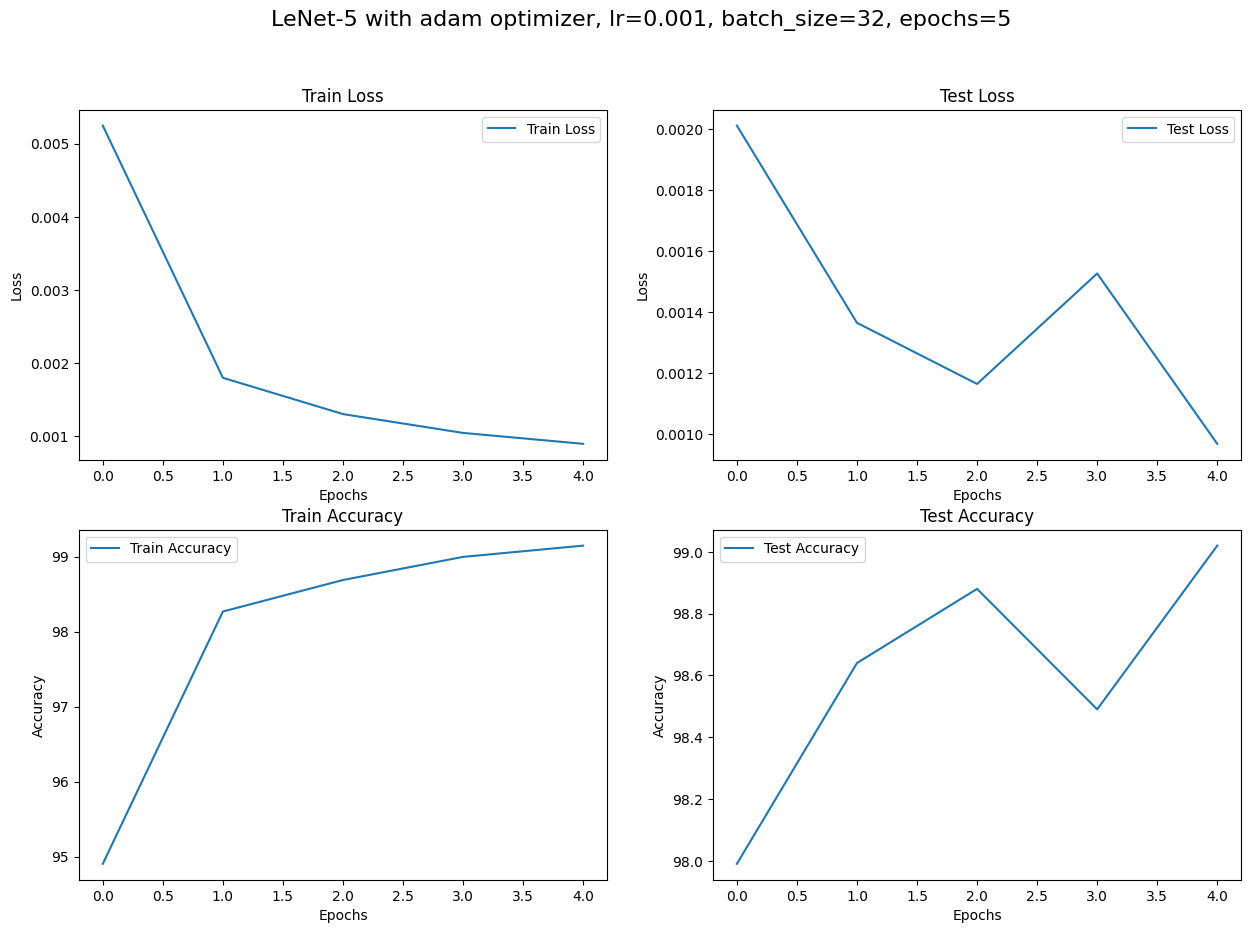

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0702 	 Accuracy: 16648/60000 (28%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 6118/10000 (61%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0341 	 Accuracy: 45102/60000 (75%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 8525/10000 (85%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0130 	 Accuracy: 52505/60000 (88%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 9009/10000 (90%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0101 	 Accuracy: 54230/60000 (90%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 9197/10000 (92%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0084 	 Accuracy: 55162/60000 (92%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 9330/10000 (93%)



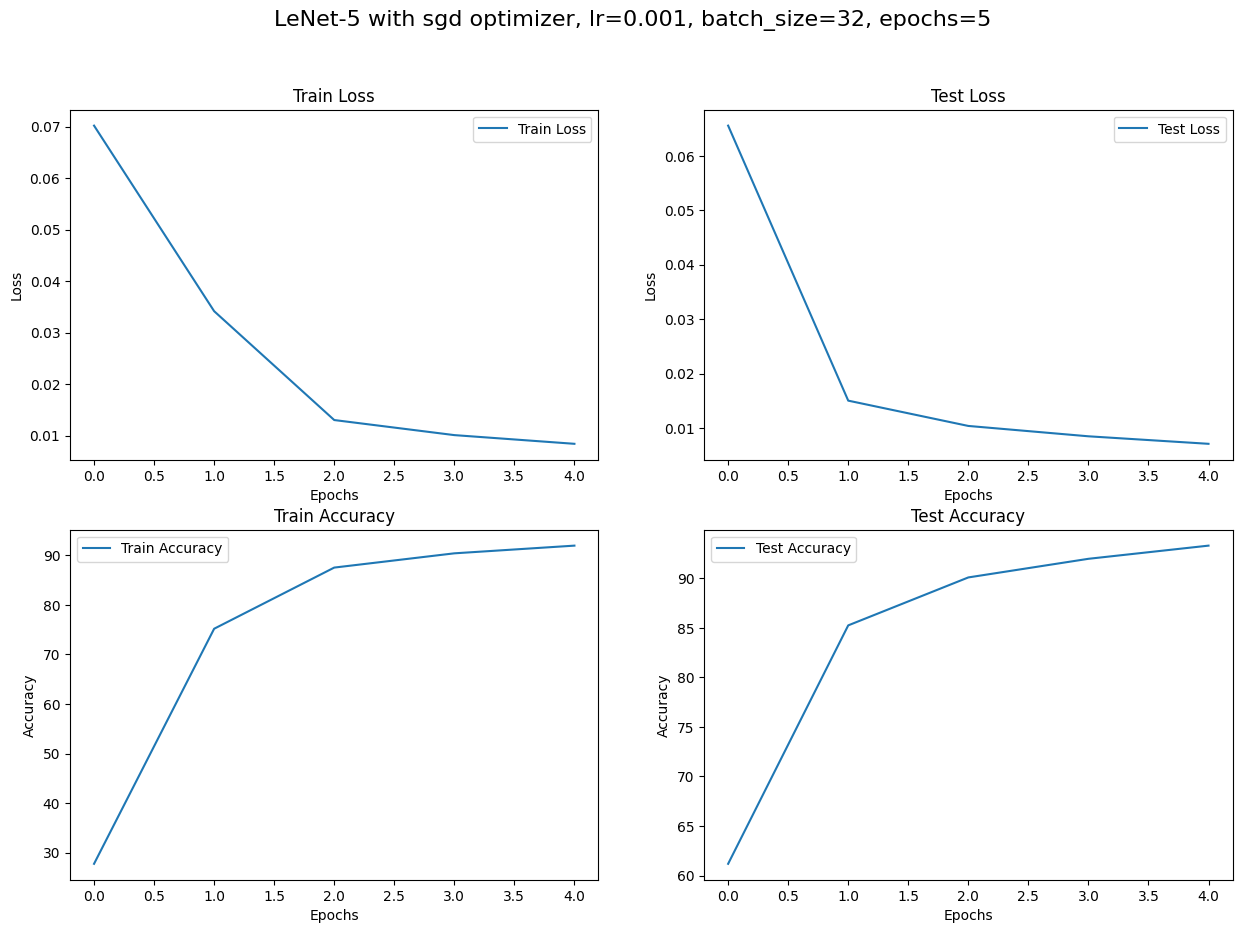

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0043 	 Accuracy: 57428/60000 (96%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 9834/10000 (98%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0017 	 Accuracy: 59004/60000 (98%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 9861/10000 (99%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0012 	 Accuracy: 59314/60000 (99%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 9864/10000 (99%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0010 	 Accuracy: 59411/60000 (99%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 9867/10000 (99%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0008 	 Accuracy: 59535/60000 (99%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 9881/10000 (99%)



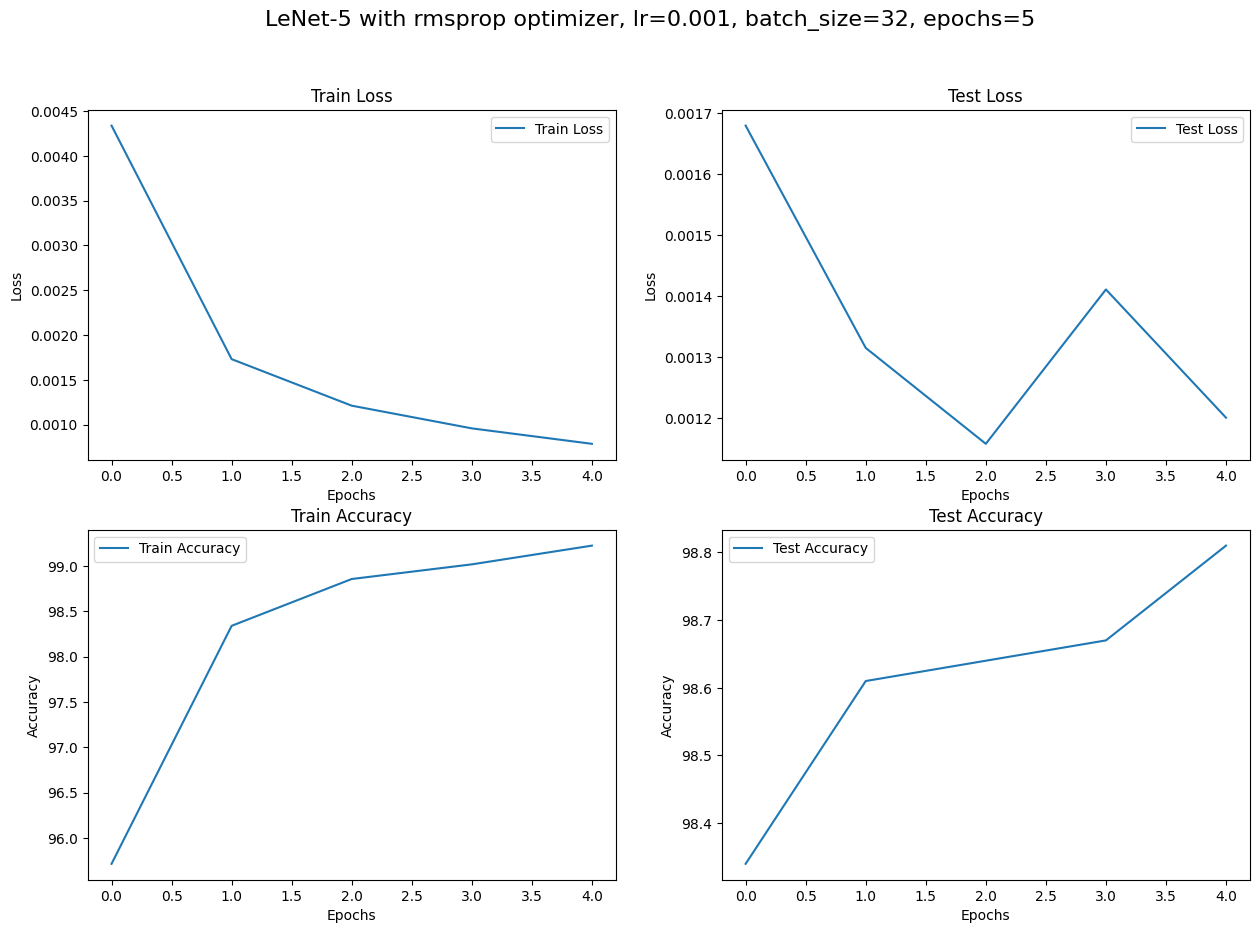

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0160 	 Accuracy: 51484/60000 (86%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 9189/10000 (92%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0082 	 Accuracy: 55440/60000 (92%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 9348/10000 (93%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0068 	 Accuracy: 56158/60000 (94%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 9445/10000 (94%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0060 	 Accuracy: 56560/60000 (94%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 9501/10000 (95%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0055 	 Accuracy: 56912/60000 (95%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 9537/10000 (95%)



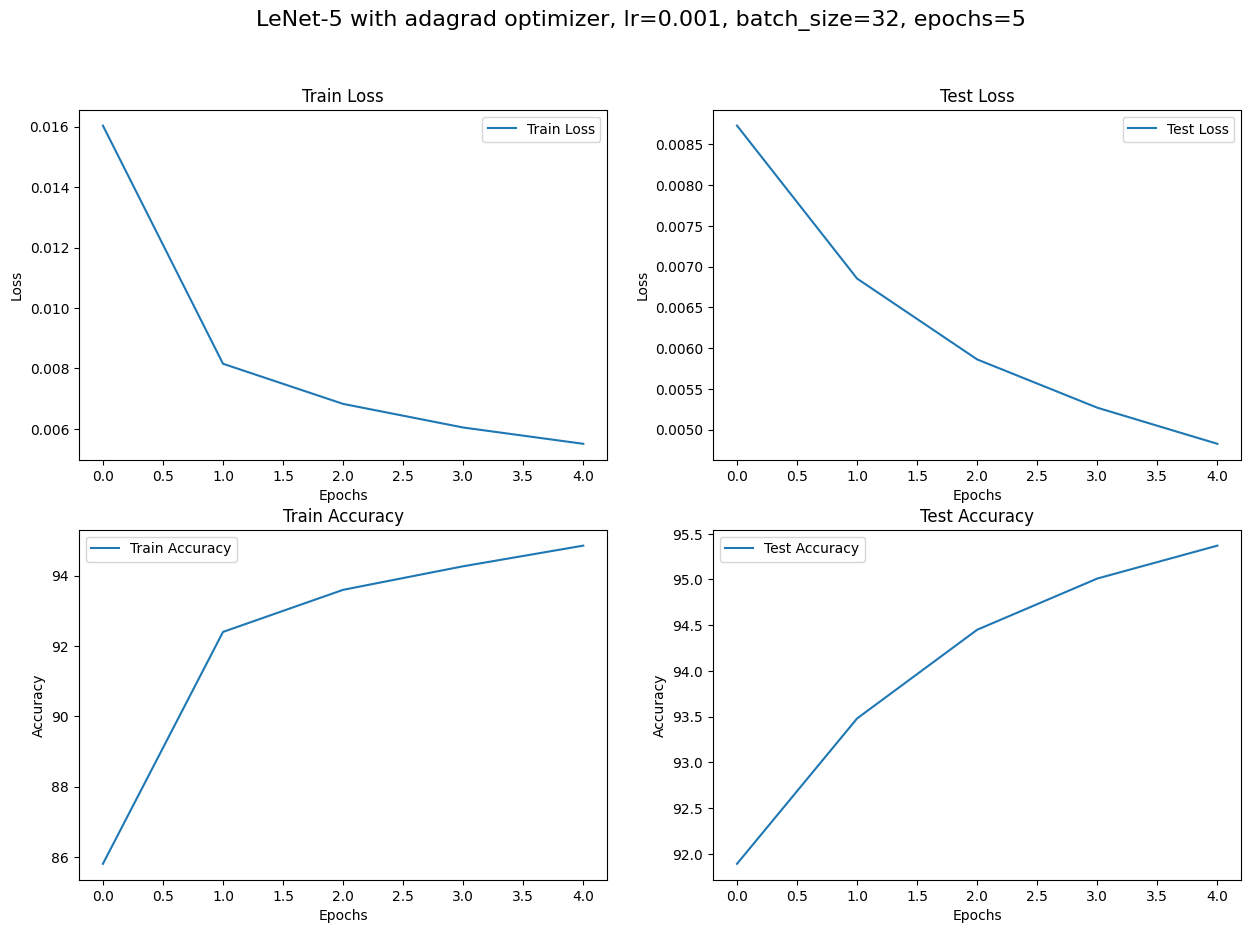

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0033 	 Accuracy: 56112/60000 (94%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 9818/10000 (98%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0009 	 Accuracy: 58906/60000 (98%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9868/10000 (99%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0007 	 Accuracy: 59201/60000 (99%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9887/10000 (99%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0005 	 Accuracy: 59338/60000 (99%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9894/10000 (99%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0004 	 Accuracy: 59452/60000 (99%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9885/10000 (99%)



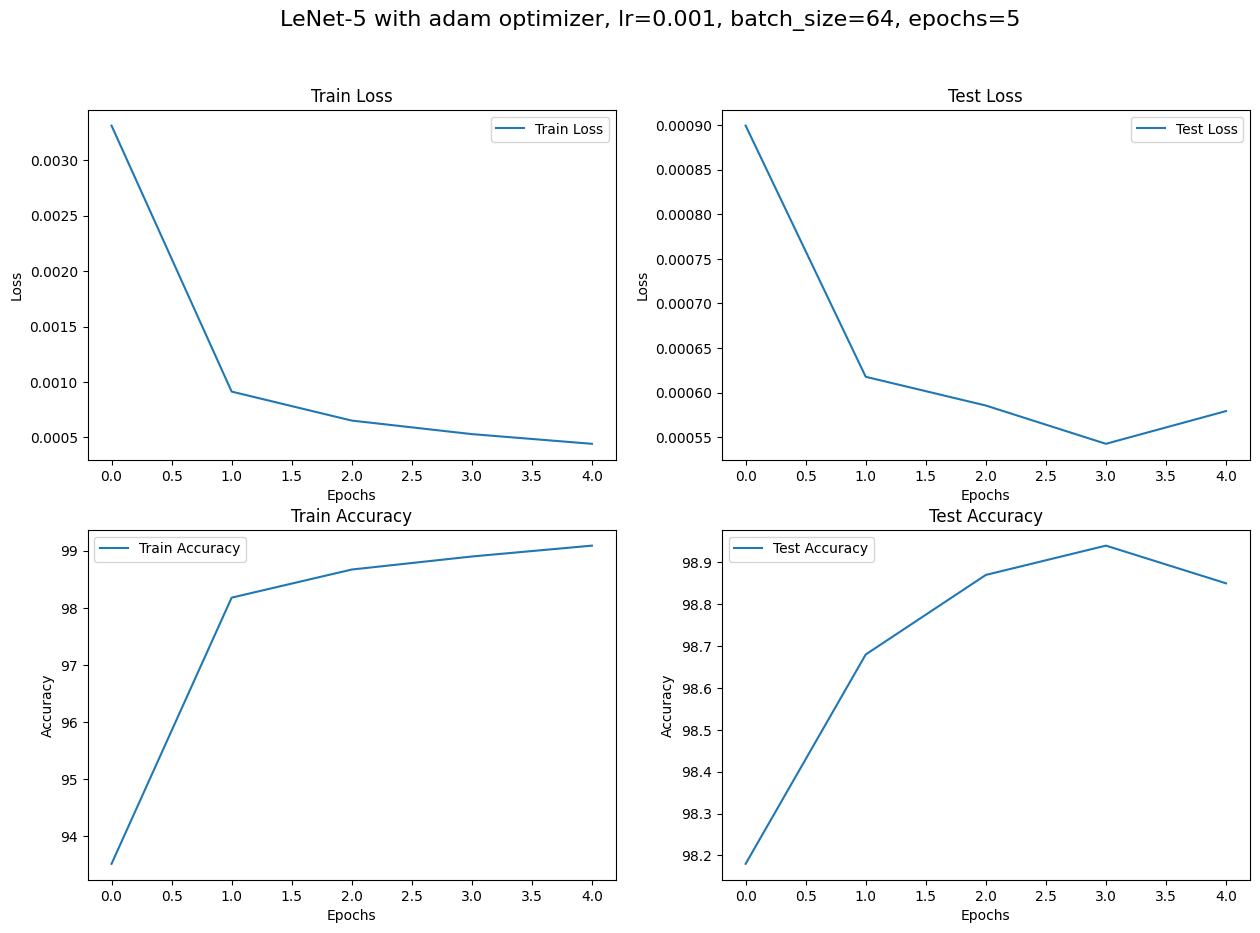

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0358 	 Accuracy: 7047/60000 (12%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 2186/10000 (22%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0346 	 Accuracy: 26217/60000 (44%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 5020/10000 (50%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0249 	 Accuracy: 38155/60000 (64%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 7822/10000 (78%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0098 	 Accuracy: 49222/60000 (82%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 8591/10000 (86%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0069 	 Accuracy: 51997/60000 (87%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 8854/10000 (89%)



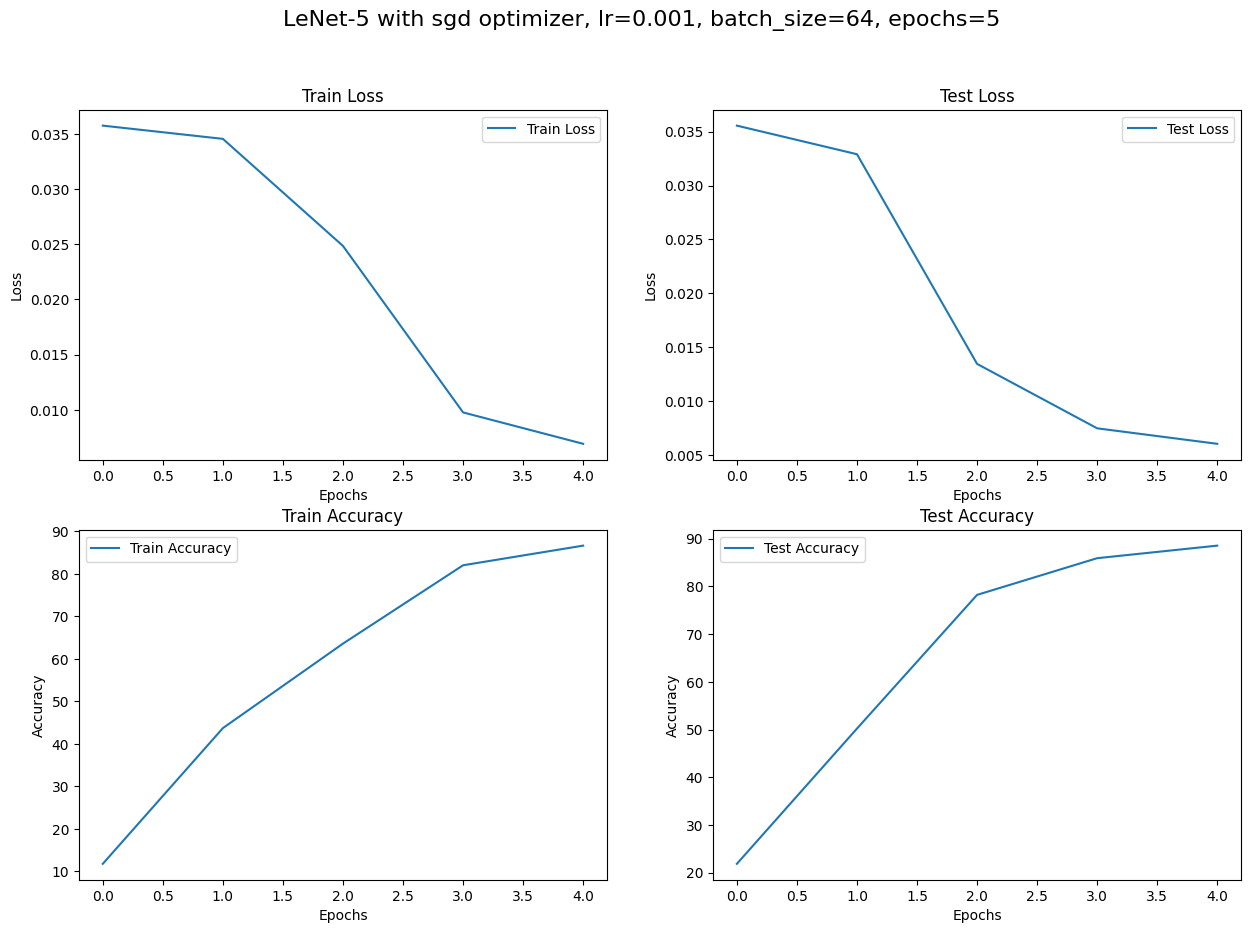

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0021 	 Accuracy: 57449/60000 (96%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 9828/10000 (98%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0008 	 Accuracy: 59058/60000 (98%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9882/10000 (99%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0006 	 Accuracy: 59316/60000 (99%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9882/10000 (99%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0005 	 Accuracy: 59432/60000 (99%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9883/10000 (99%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0004 	 Accuracy: 59567/60000 (99%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9900/10000 (99%)



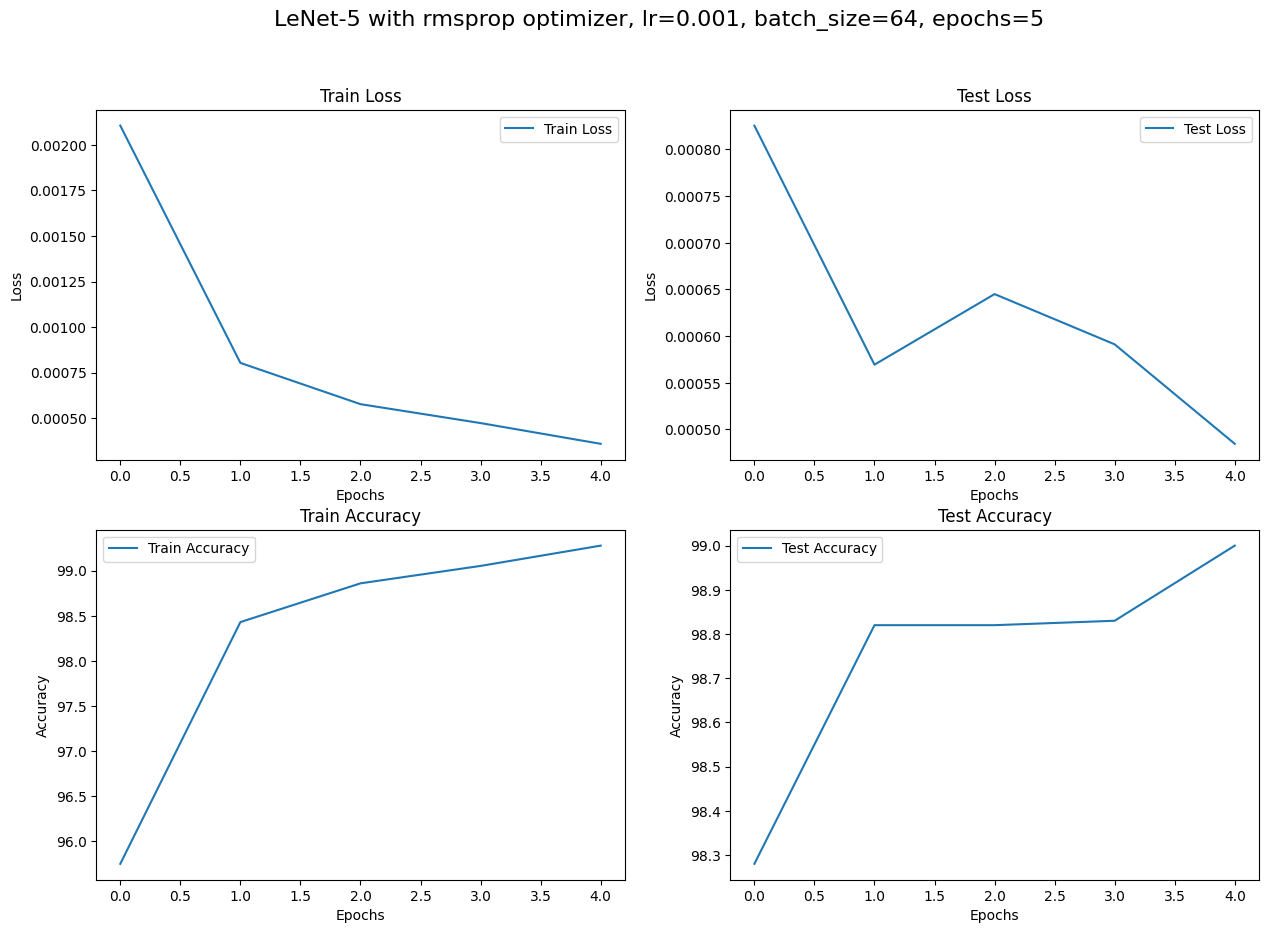

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0088 	 Accuracy: 51038/60000 (85%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 9043/10000 (90%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0049 	 Accuracy: 54514/60000 (91%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 9203/10000 (92%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0042 	 Accuracy: 55263/60000 (92%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 9291/10000 (93%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0038 	 Accuracy: 55735/60000 (93%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 9332/10000 (93%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0035 	 Accuracy: 56069/60000 (93%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 9388/10000 (94%)



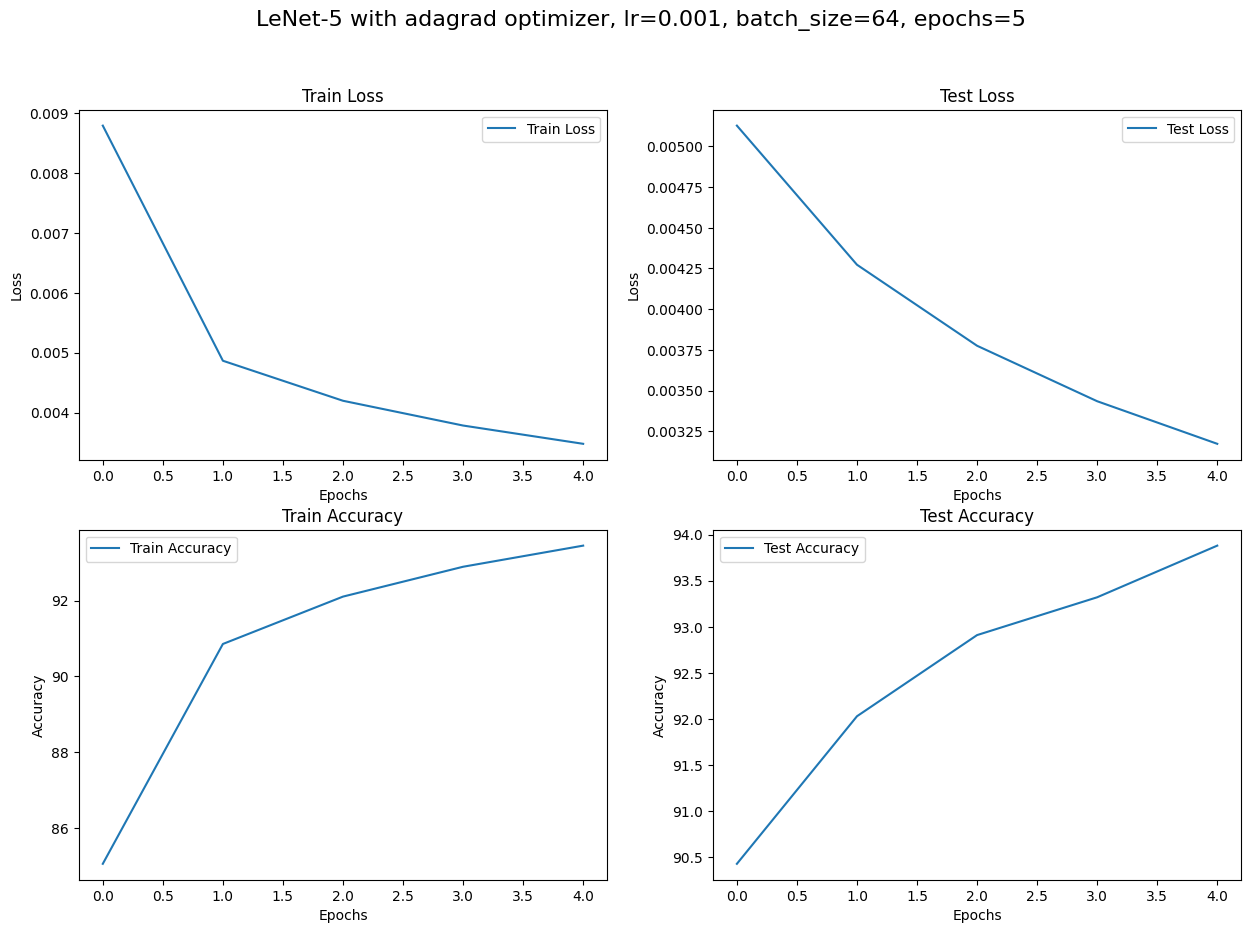

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0024 	 Accuracy: 54378/60000 (91%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9735/10000 (97%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0006 	 Accuracy: 58460/60000 (97%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9836/10000 (98%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0004 	 Accuracy: 58925/60000 (98%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9863/10000 (99%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0004 	 Accuracy: 59138/60000 (99%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9868/10000 (99%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0003 	 Accuracy: 59285/60000 (99%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Accuracy: 9901/10000 (99%)



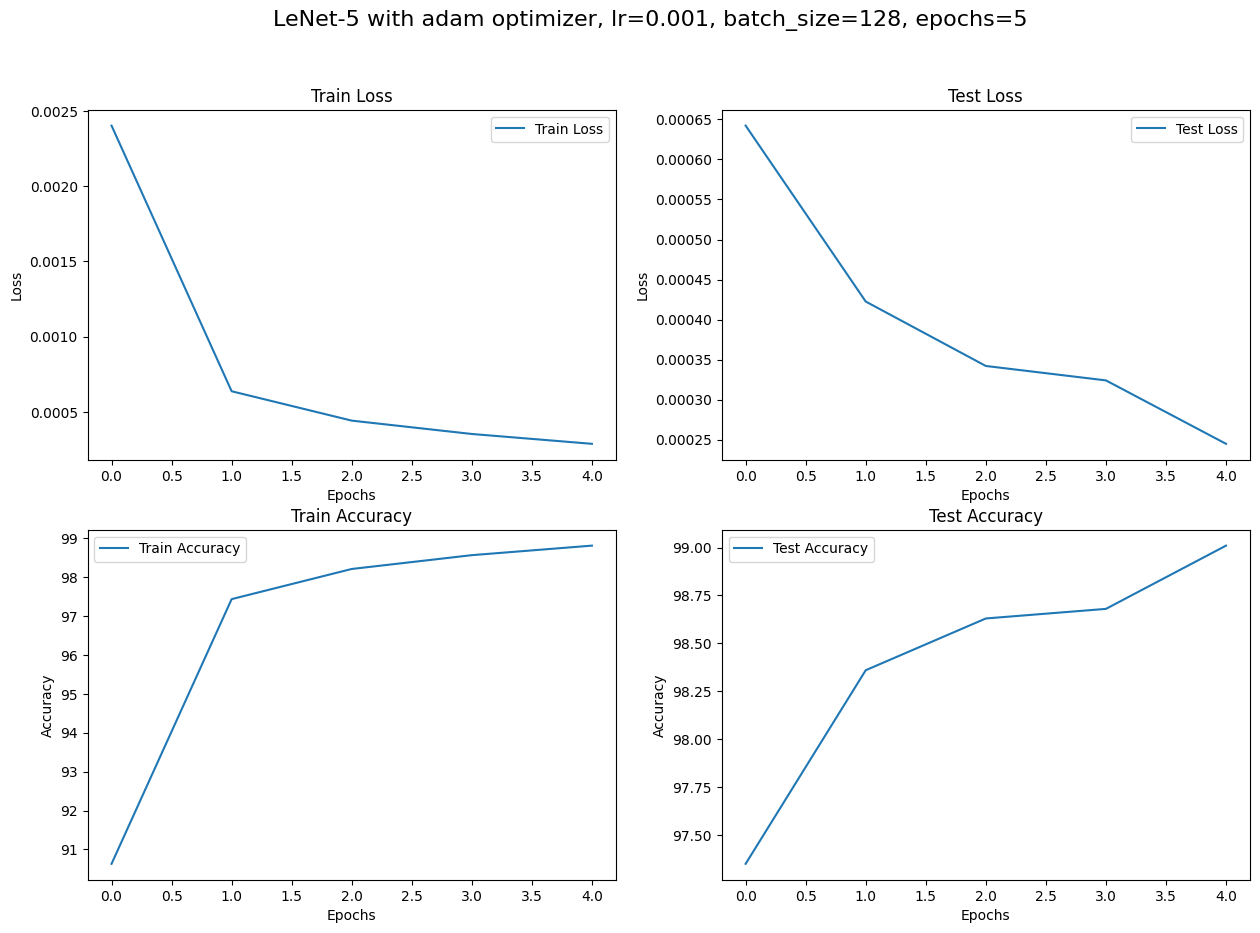

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0180 	 Accuracy: 7106/60000 (12%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 1450/10000 (14%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0178 	 Accuracy: 12406/60000 (21%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 3222/10000 (32%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0175 	 Accuracy: 24494/60000 (41%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 4438/10000 (44%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0168 	 Accuracy: 25791/60000 (43%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 4220/10000 (42%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0145 	 Accuracy: 28859/60000 (48%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 5803/10000 (58%)



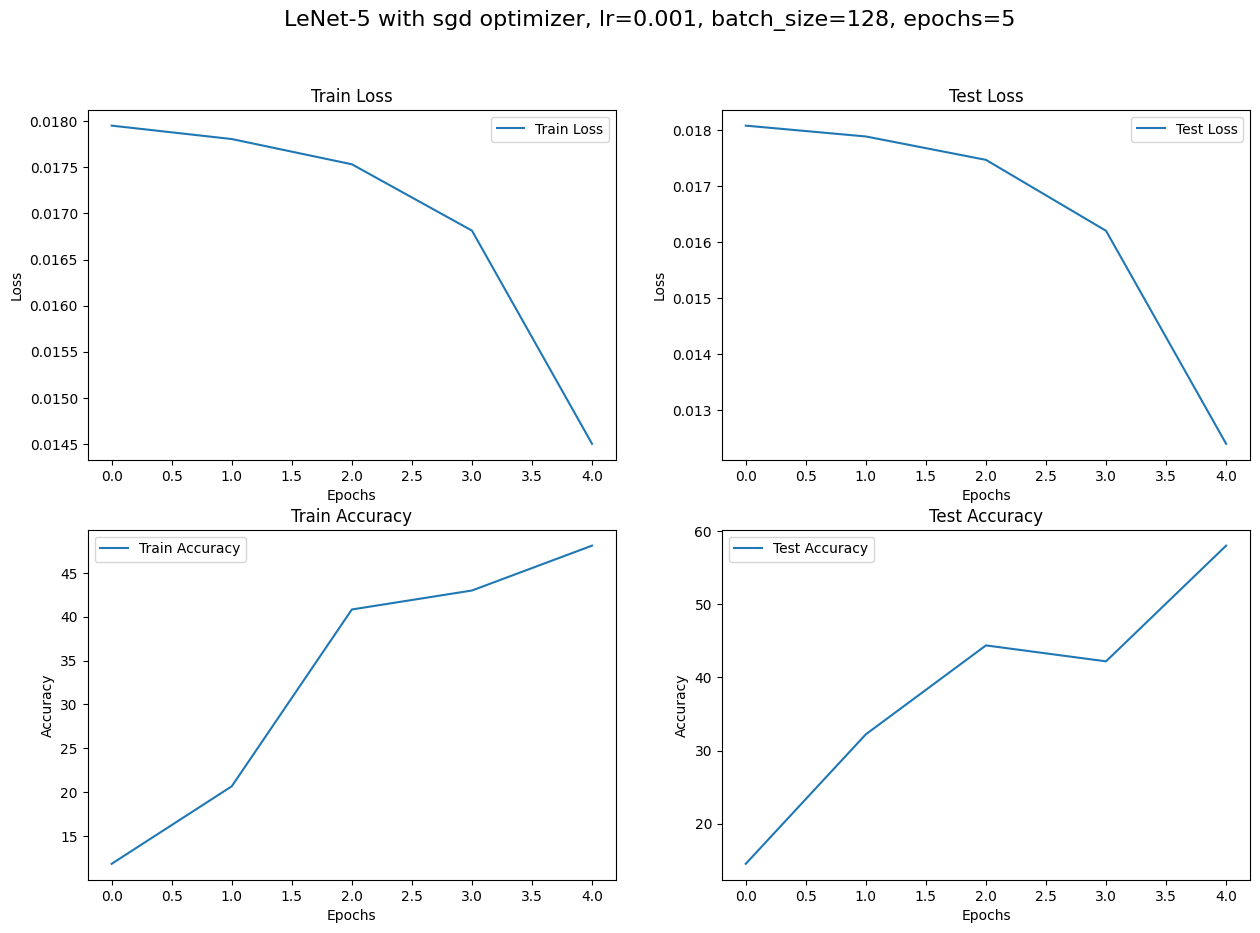

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0015 	 Accuracy: 56465/60000 (94%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 9666/10000 (97%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0005 	 Accuracy: 58885/60000 (98%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9861/10000 (99%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0003 	 Accuracy: 59209/60000 (99%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9863/10000 (99%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0003 	 Accuracy: 59391/60000 (99%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9869/10000 (99%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0002 	 Accuracy: 59473/60000 (99%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9903/10000 (99%)



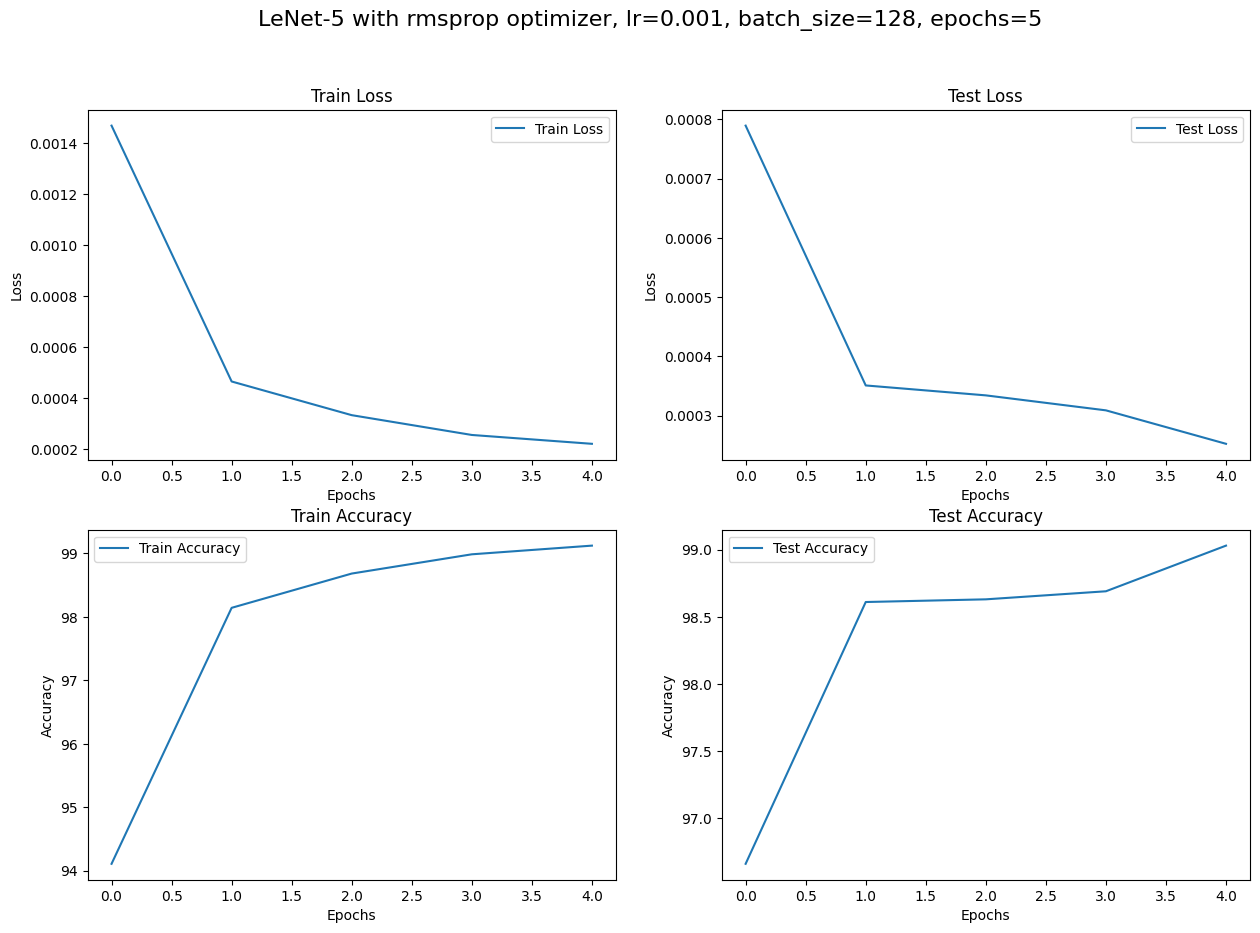

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0059 	 Accuracy: 47669/60000 (79%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8819/10000 (88%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0029 	 Accuracy: 53485/60000 (89%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9045/10000 (90%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0025 	 Accuracy: 54372/60000 (91%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9171/10000 (92%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0022 	 Accuracy: 54906/60000 (92%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 9268/10000 (93%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0020 	 Accuracy: 55362/60000 (92%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9316/10000 (93%)



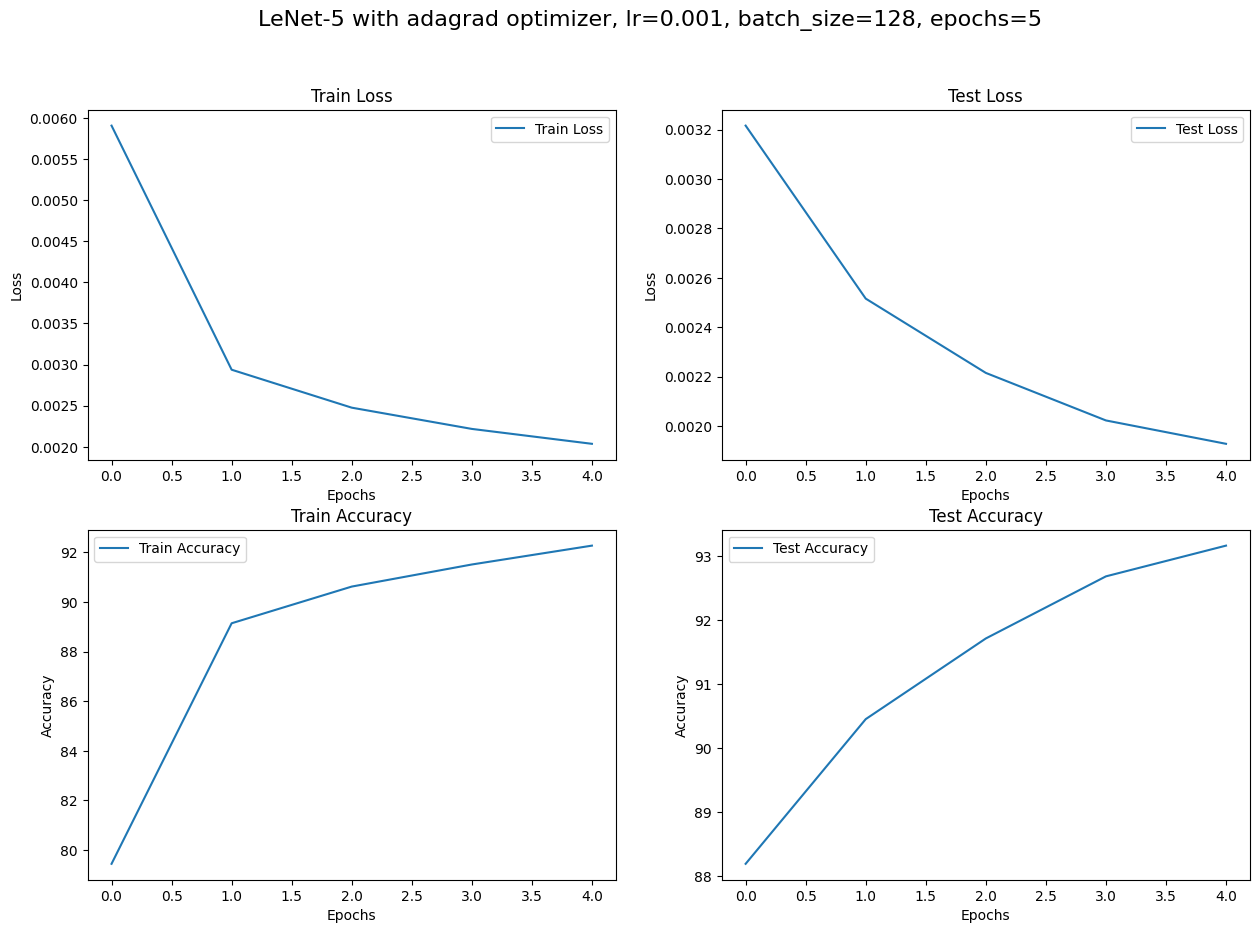

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0069 	 Accuracy: 55951/60000 (93%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 9675/10000 (97%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0022 	 Accuracy: 58674/60000 (98%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9833/10000 (98%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0016 	 Accuracy: 59058/60000 (98%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 9853/10000 (99%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0013 	 Accuracy: 59277/60000 (99%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 9875/10000 (99%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0010 	 Accuracy: 59383/60000 (99%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 9874/10000 (99%)



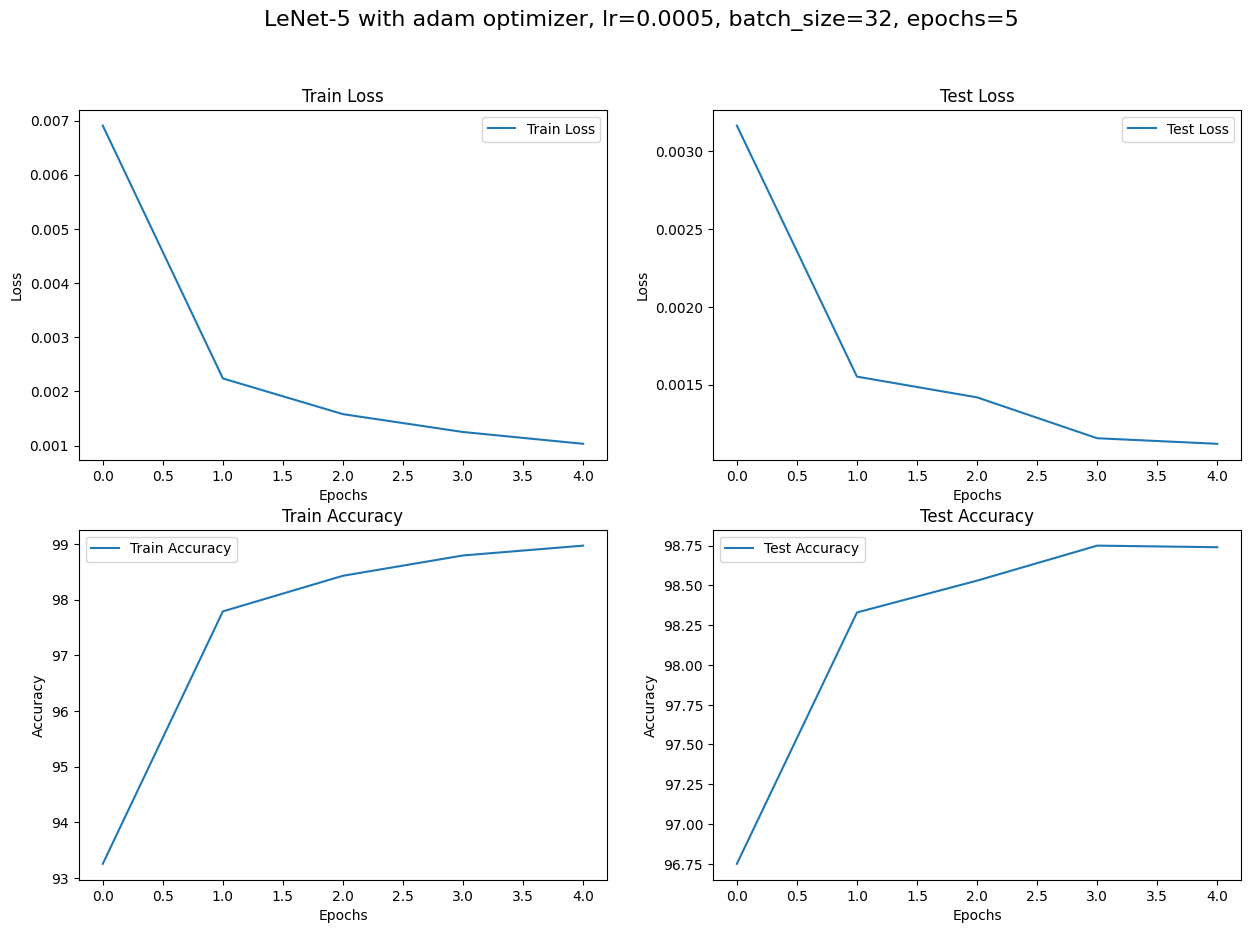

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0718 	 Accuracy: 6312/60000 (11%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0718, Accuracy: 1322/10000 (13%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0713 	 Accuracy: 14354/60000 (24%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0710, Accuracy: 3412/10000 (34%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0698 	 Accuracy: 23152/60000 (39%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0678, Accuracy: 4242/10000 (42%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0588 	 Accuracy: 29436/60000 (49%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 6900/10000 (69%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0264 	 Accuracy: 46247/60000 (77%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 8268/10000 (83%)



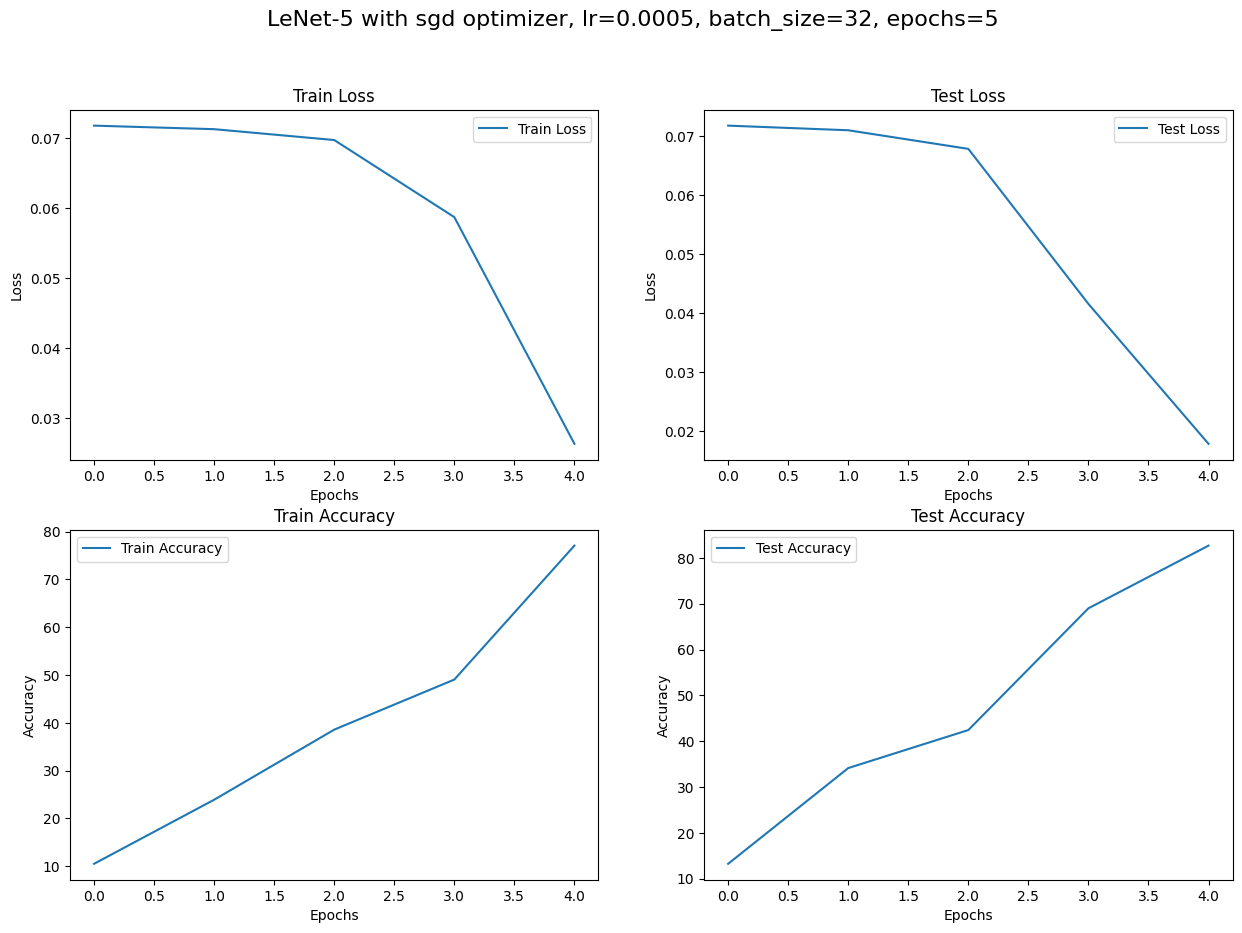

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0047 	 Accuracy: 57223/60000 (95%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 9829/10000 (98%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0018 	 Accuracy: 58926/60000 (98%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 9820/10000 (98%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0013 	 Accuracy: 59242/60000 (99%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 9889/10000 (99%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0010 	 Accuracy: 59404/60000 (99%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 9894/10000 (99%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0008 	 Accuracy: 59521/60000 (99%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 9894/10000 (99%)



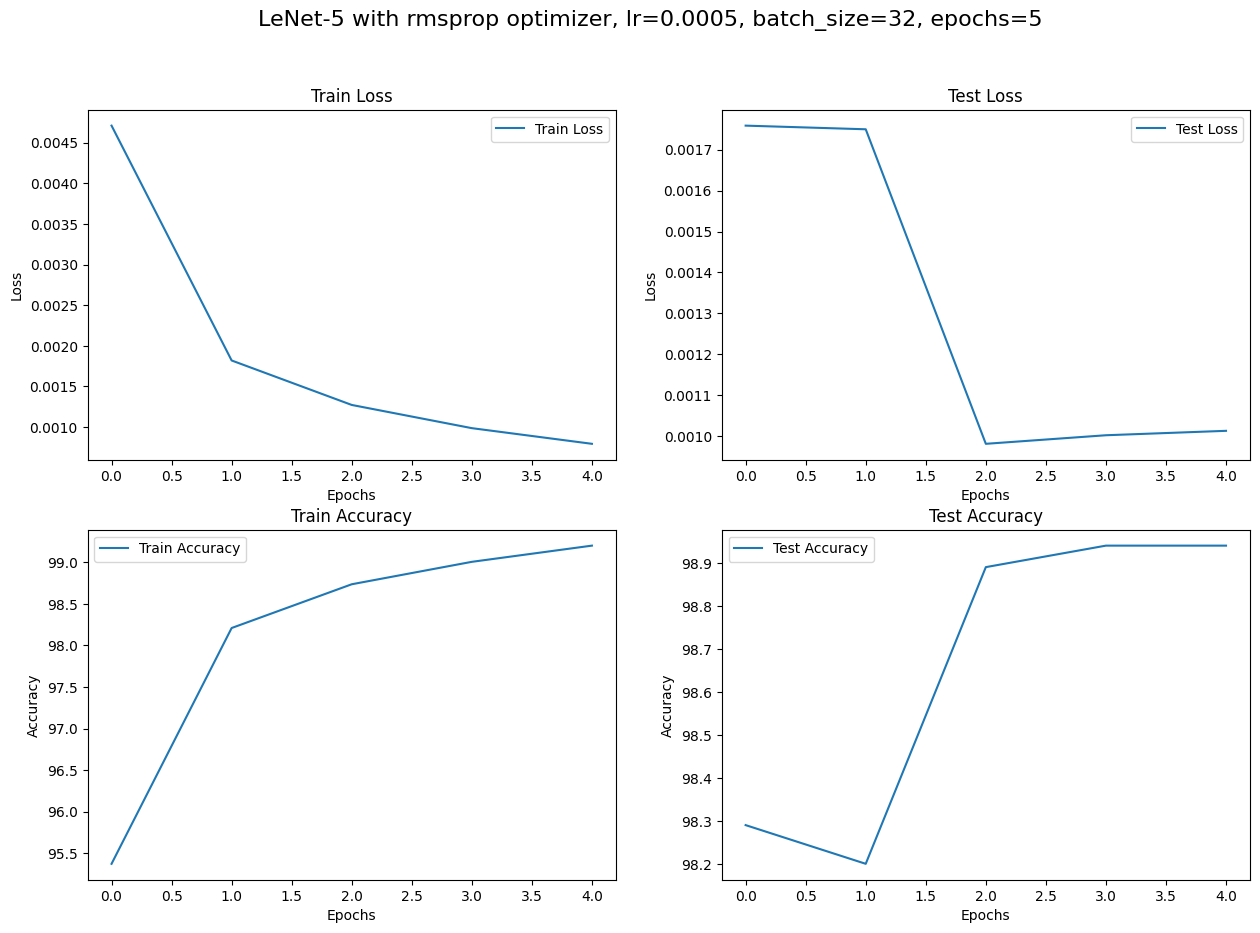

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0269 	 Accuracy: 46869/60000 (78%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 8787/10000 (88%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0127 	 Accuracy: 53135/60000 (89%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 9031/10000 (90%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0107 	 Accuracy: 54178/60000 (90%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 9156/10000 (92%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0097 	 Accuracy: 54735/60000 (91%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 9235/10000 (92%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0089 	 Accuracy: 55098/60000 (92%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 9268/10000 (93%)



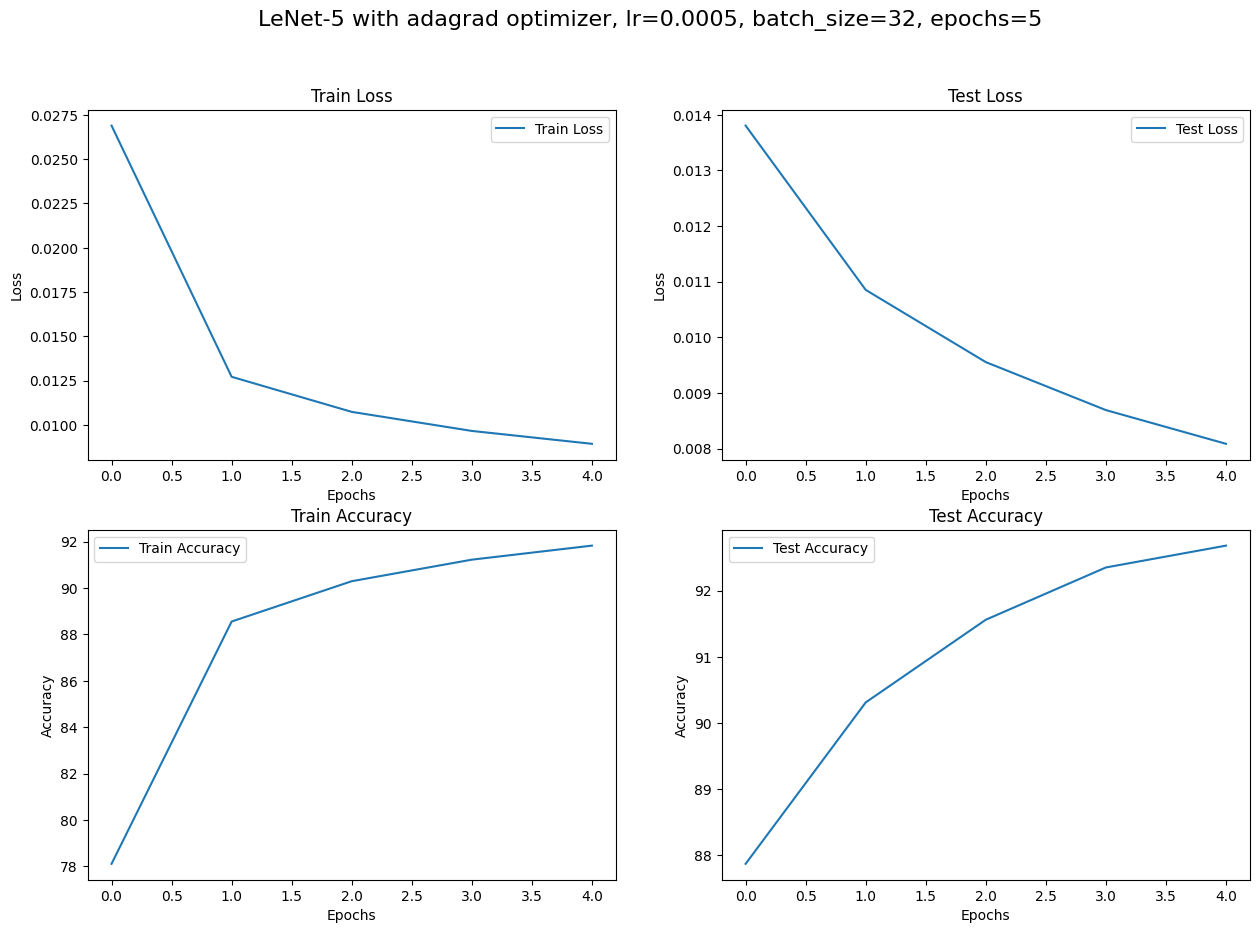

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0051 	 Accuracy: 54267/60000 (90%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 9706/10000 (97%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0013 	 Accuracy: 58474/60000 (97%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 9832/10000 (98%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0009 	 Accuracy: 58948/60000 (98%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9850/10000 (98%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0007 	 Accuracy: 59119/60000 (99%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9878/10000 (99%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0006 	 Accuracy: 59251/60000 (99%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9852/10000 (99%)



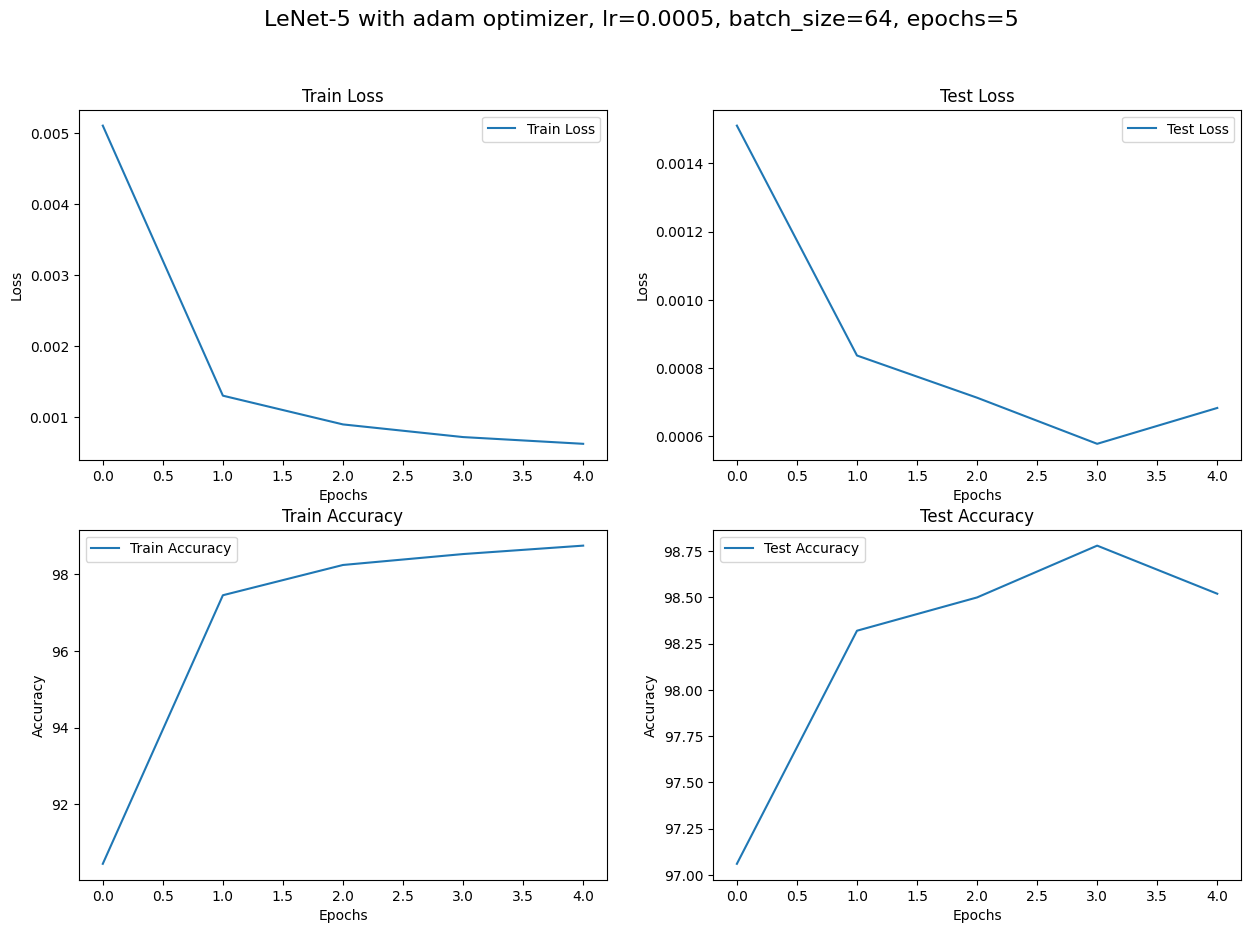

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0360 	 Accuracy: 5543/60000 (9%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 1083/10000 (11%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0357 	 Accuracy: 10416/60000 (17%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 2733/10000 (27%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0353 	 Accuracy: 18992/60000 (32%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 3490/10000 (35%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0345 	 Accuracy: 22428/60000 (37%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 4342/10000 (43%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0320 	 Accuracy: 31422/60000 (52%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 6601/10000 (66%)



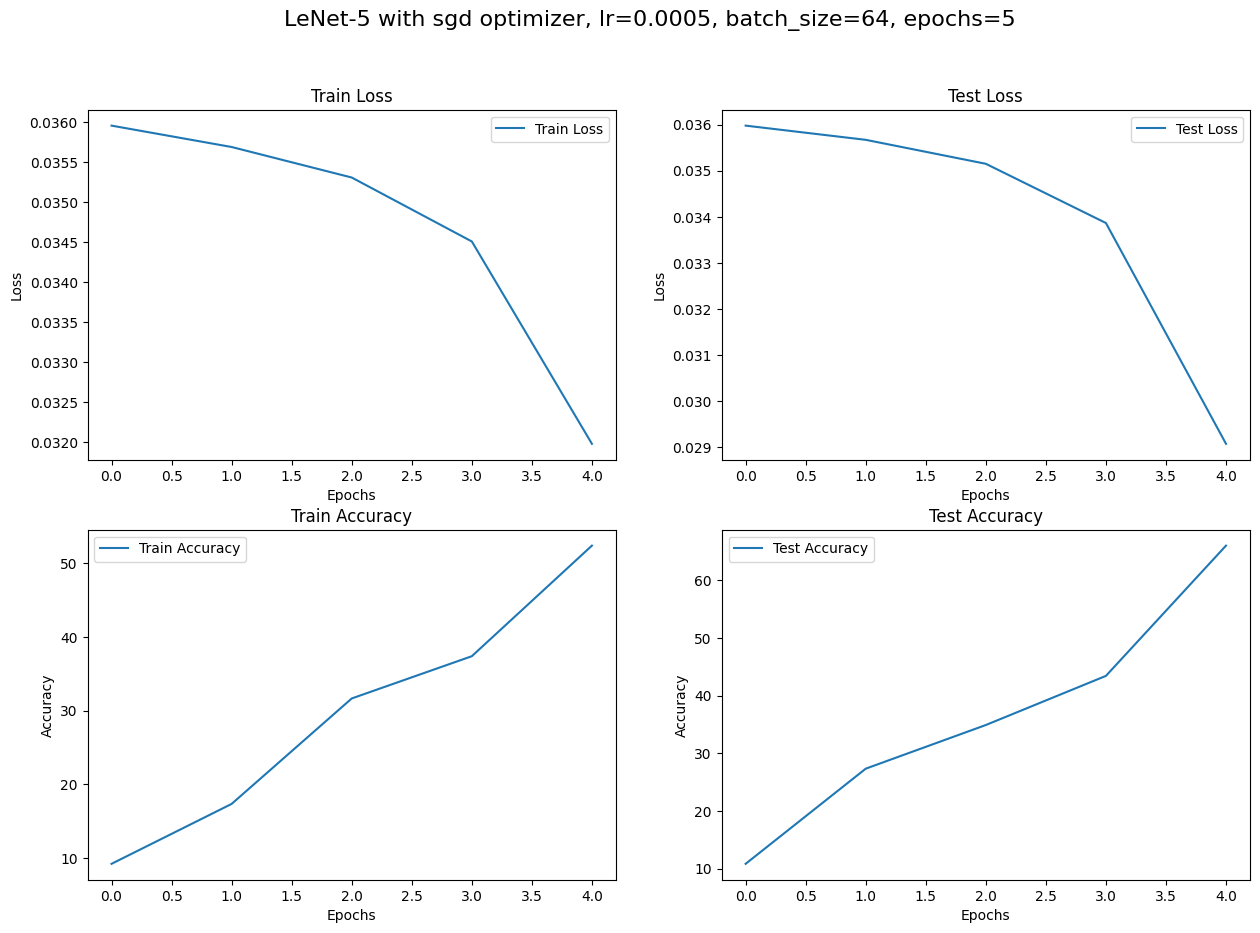

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0035 	 Accuracy: 55783/60000 (93%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 9762/10000 (98%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0012 	 Accuracy: 58595/60000 (98%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 9764/10000 (98%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0008 	 Accuracy: 59032/60000 (98%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 9760/10000 (98%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0006 	 Accuracy: 59198/60000 (99%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9876/10000 (99%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0005 	 Accuracy: 59408/60000 (99%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9901/10000 (99%)



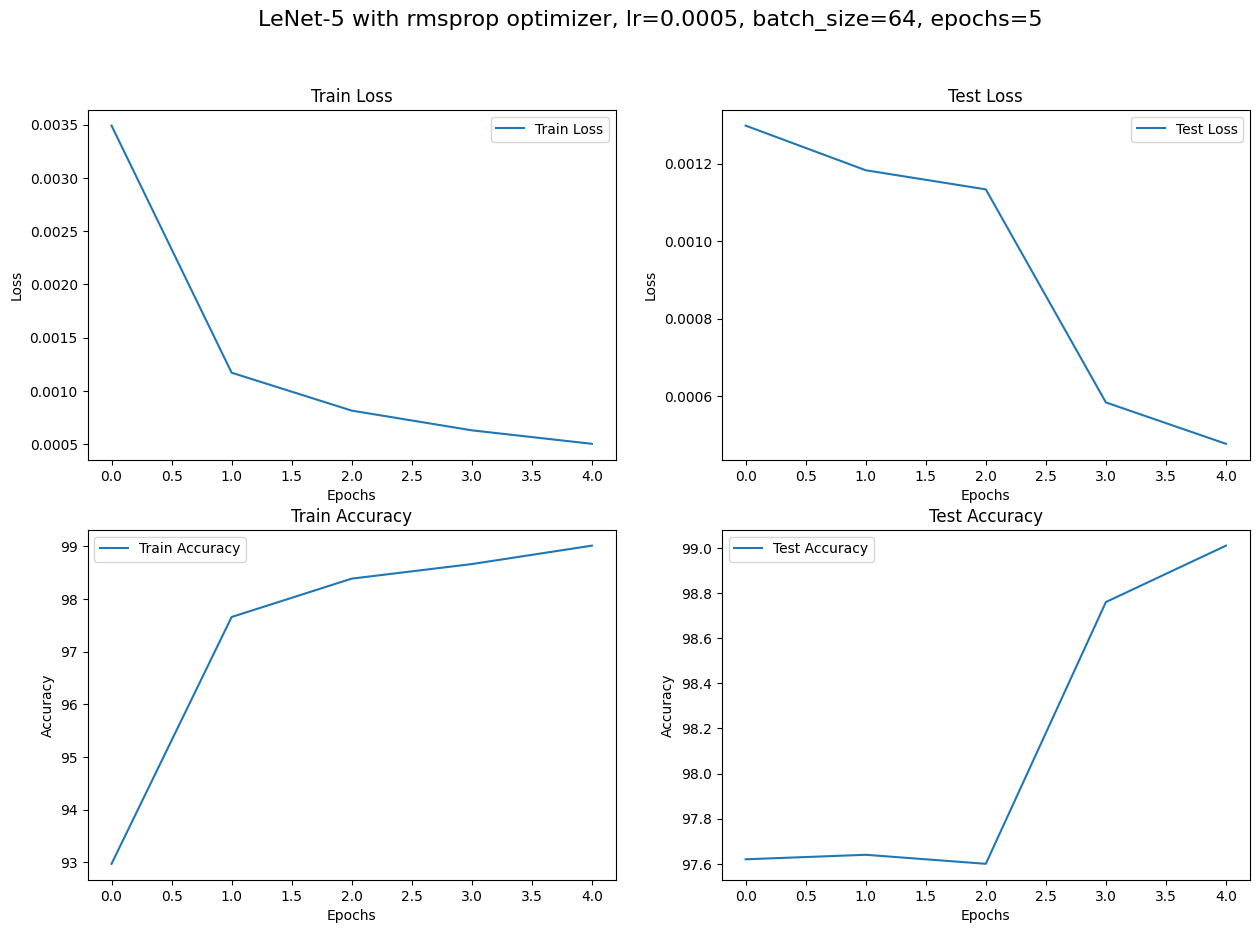

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0151 	 Accuracy: 46114/60000 (77%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8766/10000 (88%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0066 	 Accuracy: 53048/60000 (88%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 9029/10000 (90%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0055 	 Accuracy: 54116/60000 (90%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 9123/10000 (91%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0049 	 Accuracy: 54659/60000 (91%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 9198/10000 (92%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0046 	 Accuracy: 55037/60000 (92%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 9223/10000 (92%)



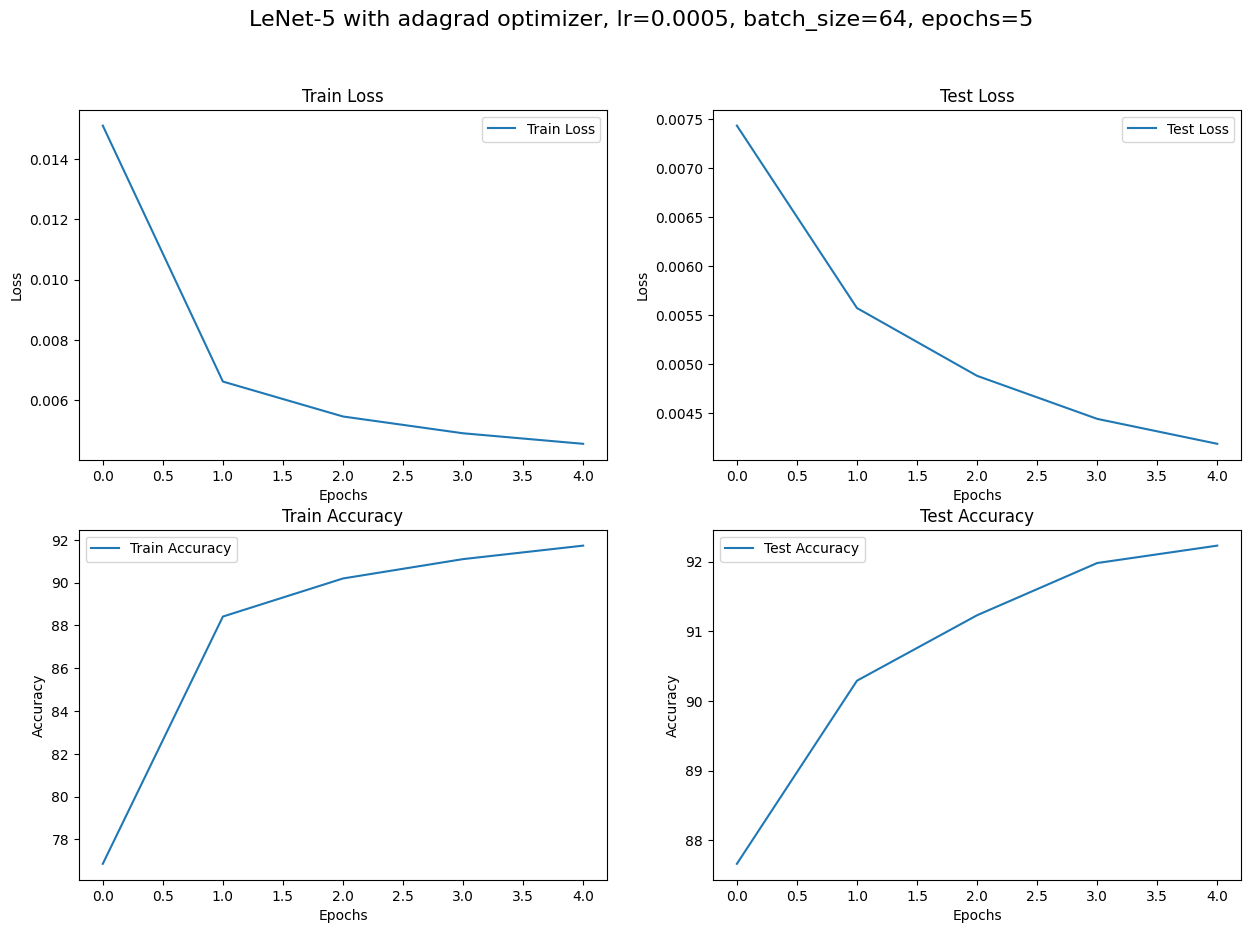

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0031 	 Accuracy: 53095/60000 (88%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 9622/10000 (96%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0009 	 Accuracy: 58019/60000 (97%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9764/10000 (98%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0006 	 Accuracy: 58559/60000 (98%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9822/10000 (98%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0005 	 Accuracy: 58893/60000 (98%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9841/10000 (98%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0004 	 Accuracy: 59081/60000 (98%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9860/10000 (99%)



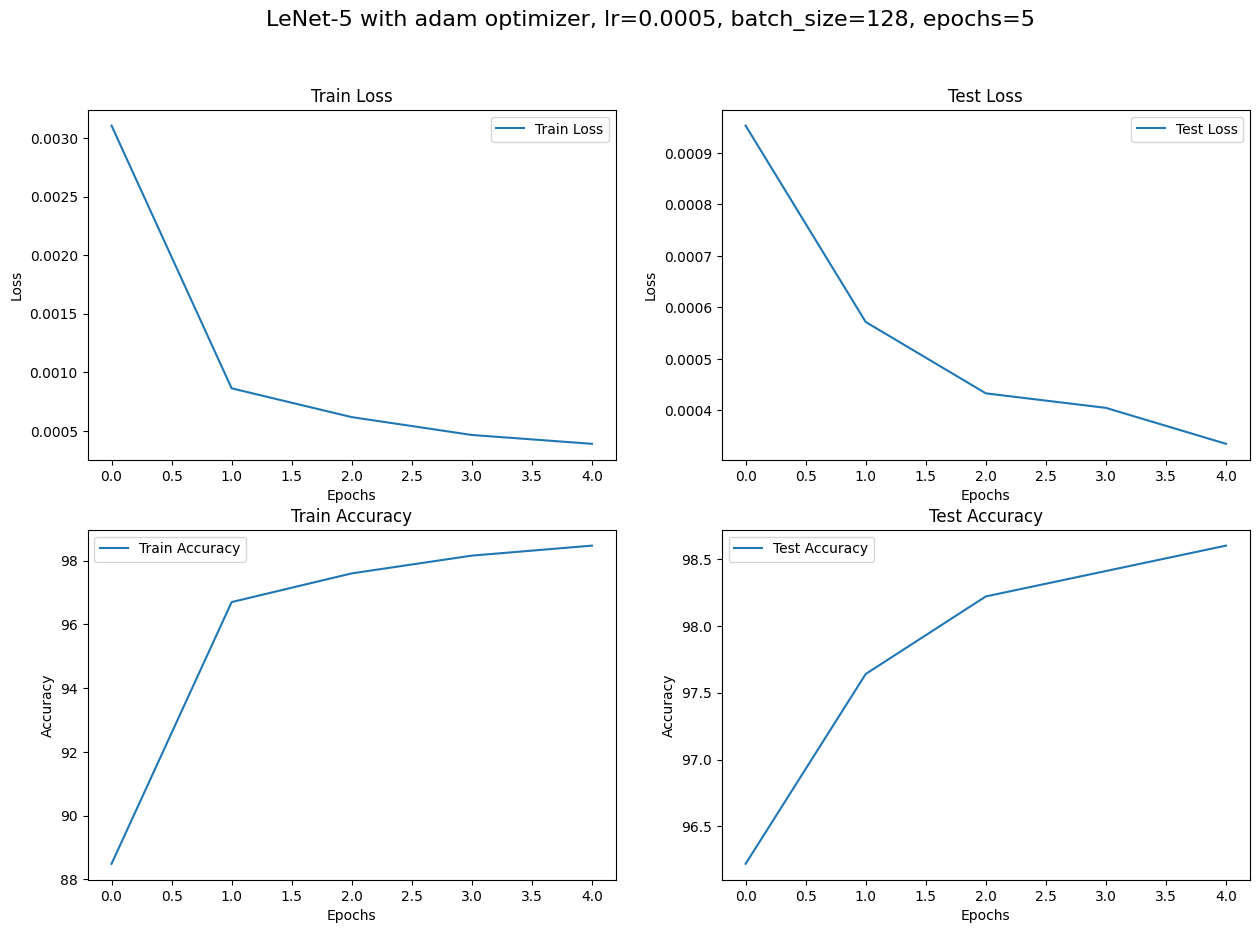

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0180 	 Accuracy: 7100/60000 (12%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 1287/10000 (13%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0180 	 Accuracy: 8282/60000 (14%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 1431/10000 (14%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0179 	 Accuracy: 8862/60000 (15%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 1465/10000 (15%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0179 	 Accuracy: 8627/60000 (14%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 1396/10000 (14%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0179 	 Accuracy: 8360/60000 (14%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 1399/10000 (14%)



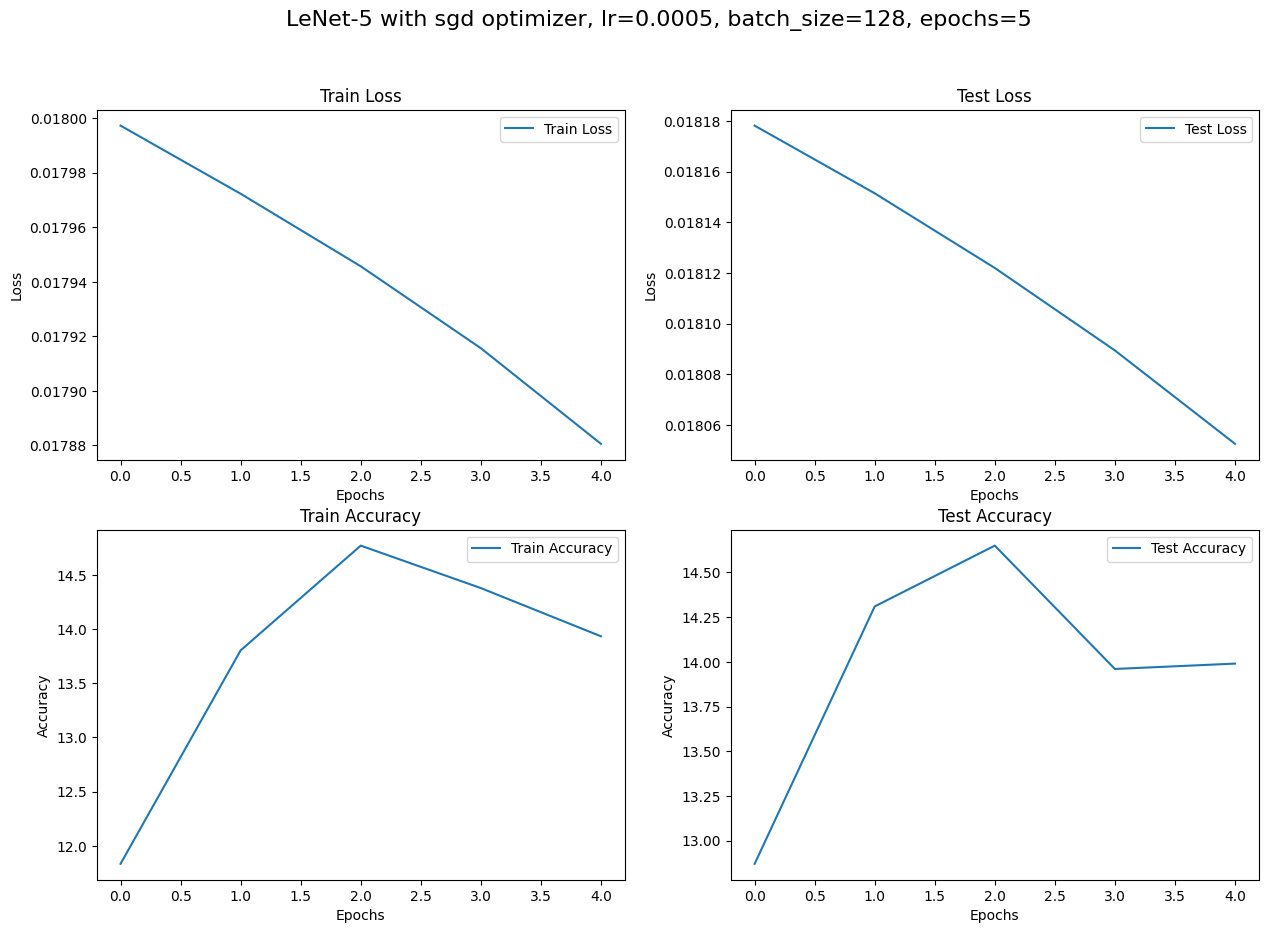

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0024 	 Accuracy: 54030/60000 (90%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 9681/10000 (97%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0007 	 Accuracy: 58246/60000 (97%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9774/10000 (98%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0005 	 Accuracy: 58805/60000 (98%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9868/10000 (99%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0004 	 Accuracy: 59057/60000 (98%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9864/10000 (99%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0003 	 Accuracy: 59257/60000 (99%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9880/10000 (99%)



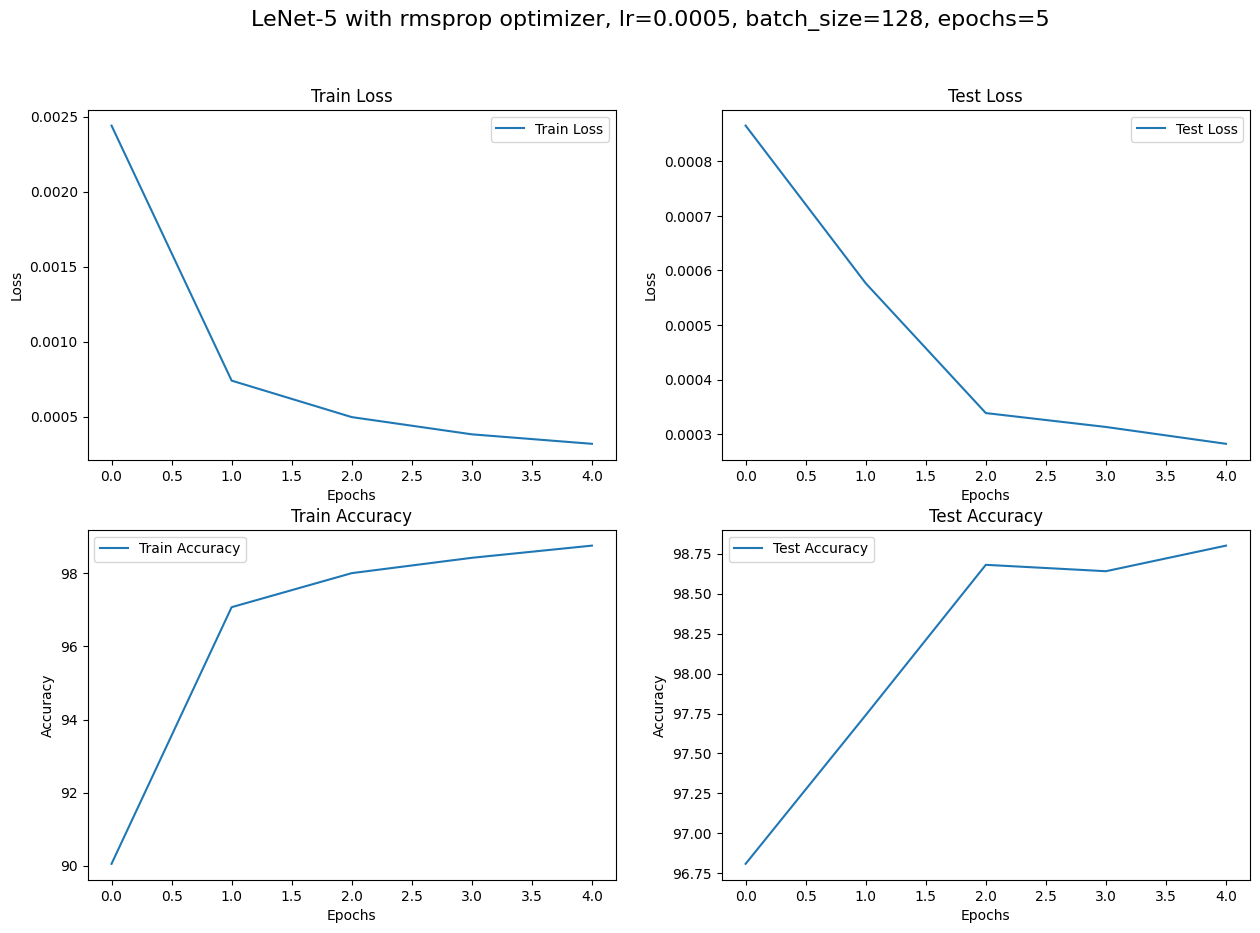

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0111 	 Accuracy: 38111/60000 (64%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8147/10000 (81%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0052 	 Accuracy: 49948/60000 (83%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8586/10000 (86%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0040 	 Accuracy: 51777/60000 (86%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8770/10000 (88%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0034 	 Accuracy: 52599/60000 (88%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8861/10000 (89%)



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0031 	 Accuracy: 53163/60000 (89%)



Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8966/10000 (90%)



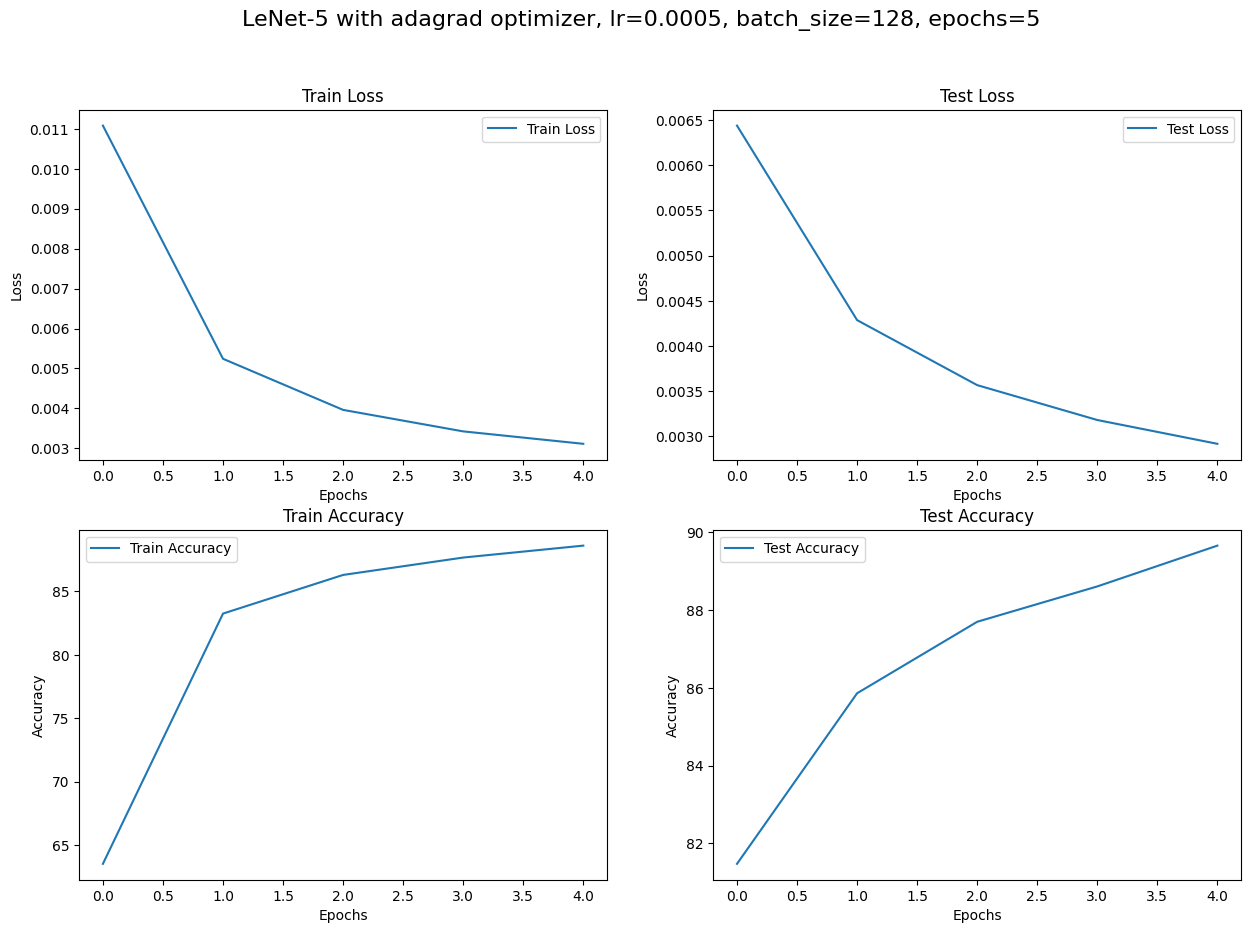

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0148 	 Accuracy: 52203/60000 (87%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 9448/10000 (94%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0049 	 Accuracy: 57215/60000 (95%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 9665/10000 (97%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0036 	 Accuracy: 57936/60000 (97%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 9724/10000 (97%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0029 	 Accuracy: 58317/60000 (97%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9785/10000 (98%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0024 	 Accuracy: 58561/60000 (98%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9775/10000 (98%)



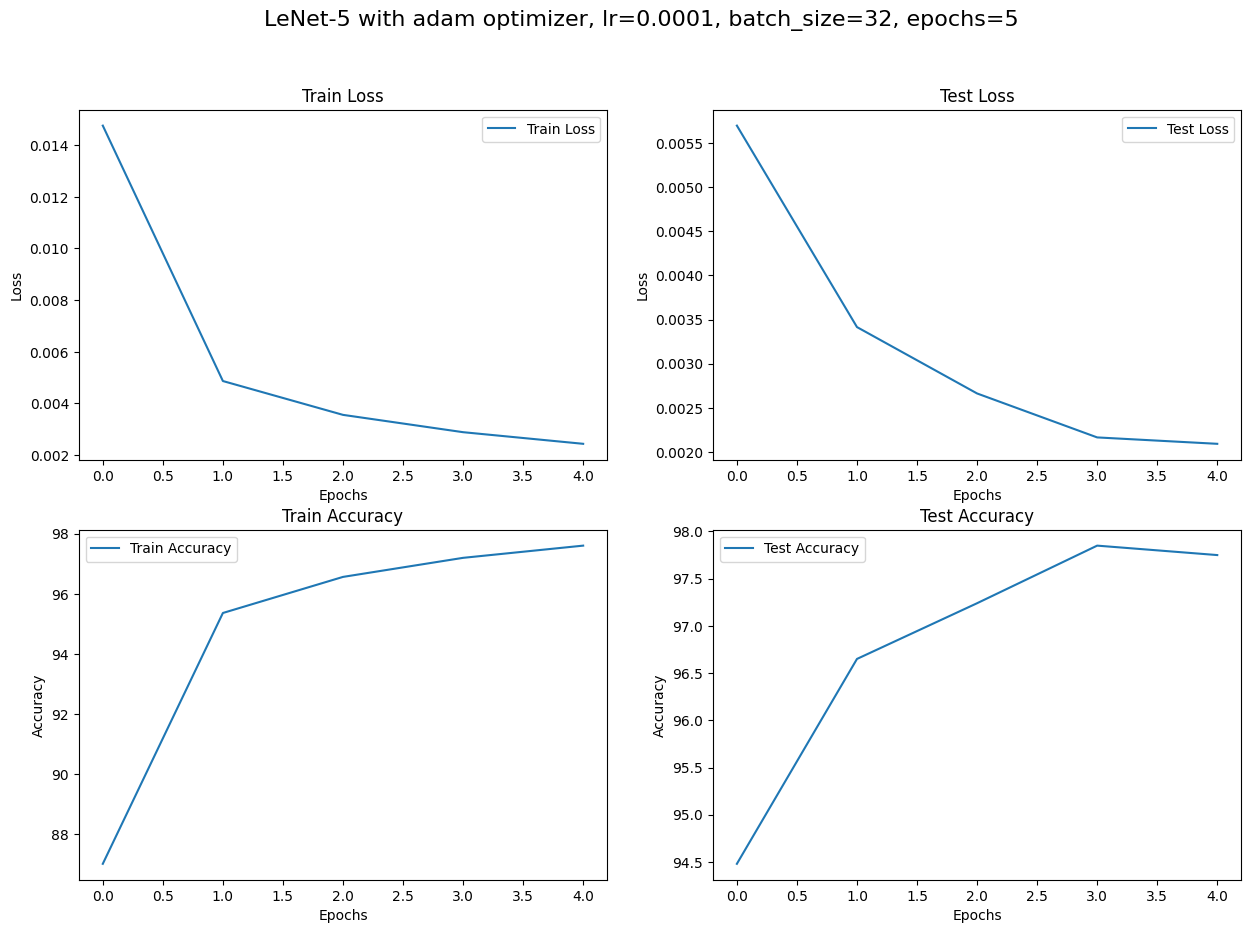

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0720 	 Accuracy: 6628/60000 (11%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0721, Accuracy: 1180/10000 (12%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0720 	 Accuracy: 7299/60000 (12%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0721, Accuracy: 1254/10000 (13%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0719 	 Accuracy: 7747/60000 (13%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0721, Accuracy: 1345/10000 (13%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0719 	 Accuracy: 8349/60000 (14%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0720, Accuracy: 1535/10000 (15%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0719 	 Accuracy: 10229/60000 (17%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0720, Accuracy: 1993/10000 (20%)



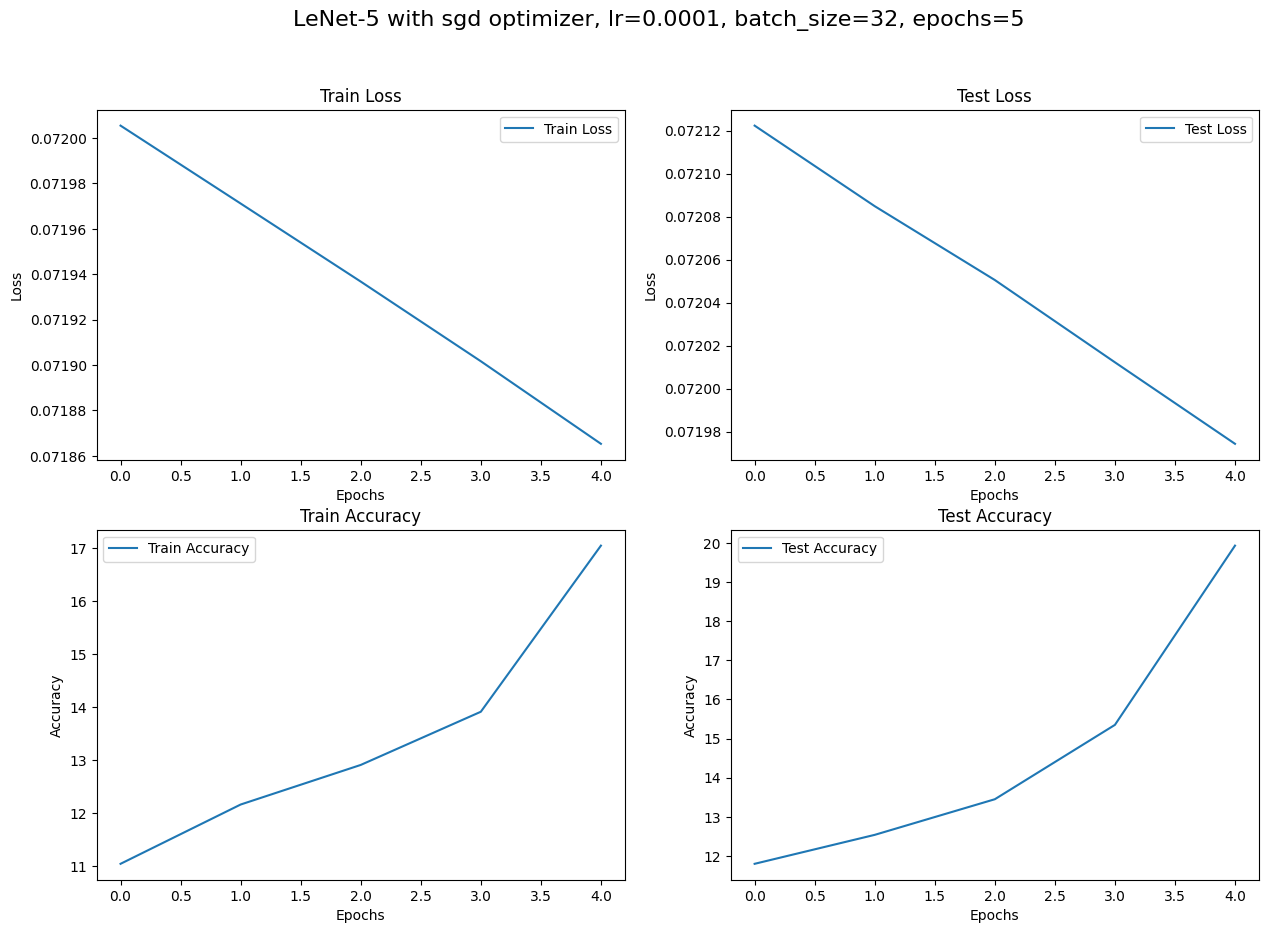

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0124 	 Accuracy: 53468/60000 (89%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 9498/10000 (95%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0044 	 Accuracy: 57423/60000 (96%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 9698/10000 (97%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0030 	 Accuracy: 58249/60000 (97%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 9721/10000 (97%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0024 	 Accuracy: 58604/60000 (98%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 9786/10000 (98%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0020 	 Accuracy: 58814/60000 (98%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9834/10000 (98%)



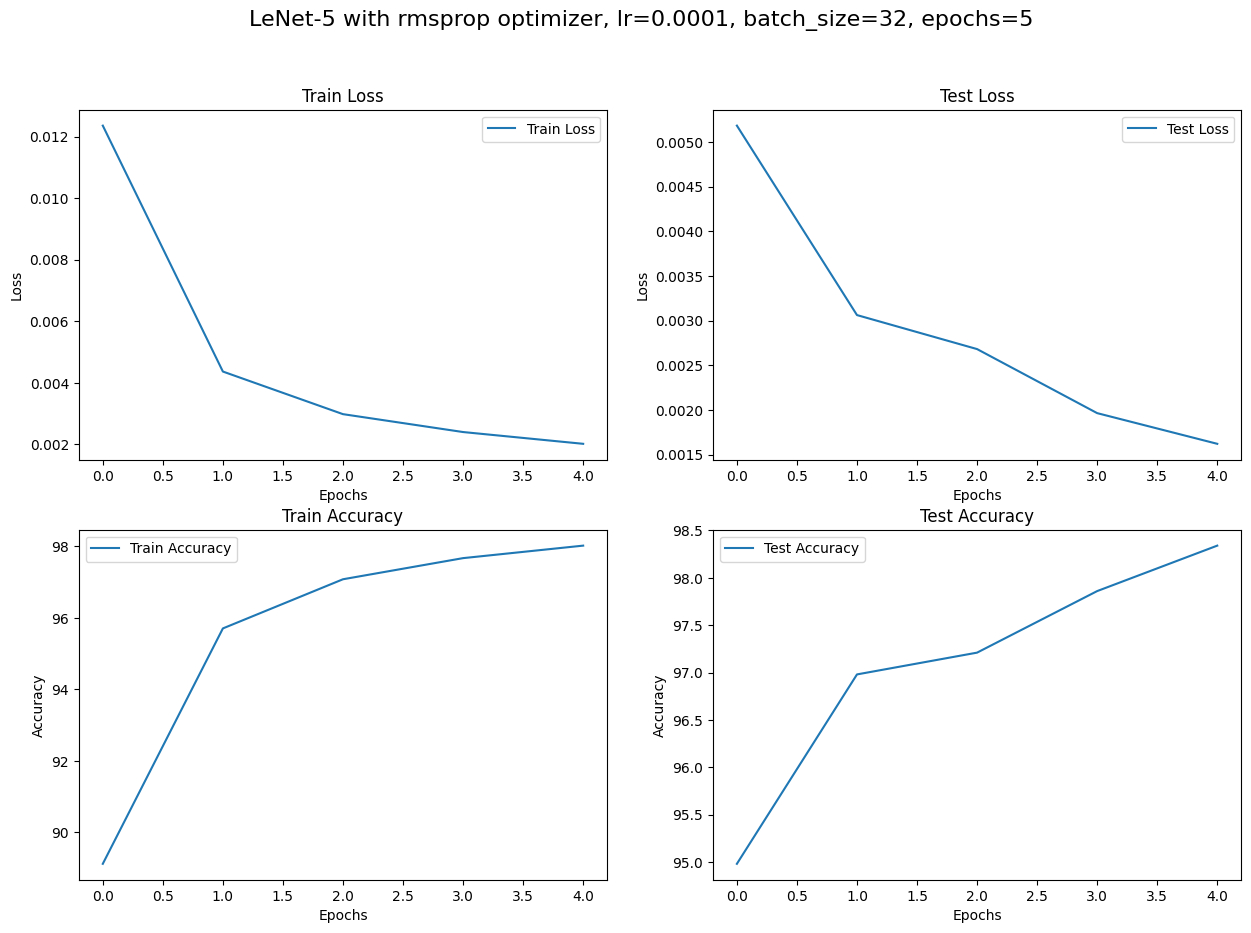

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0691 	 Accuracy: 26915/60000 (45%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0660, Accuracy: 5429/10000 (54%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0624 	 Accuracy: 36376/60000 (61%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 6874/10000 (69%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0544 	 Accuracy: 42551/60000 (71%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 7575/10000 (76%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0459 	 Accuracy: 44954/60000 (75%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 7760/10000 (78%)



Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0387 	 Accuracy: 46224/60000 (77%)



Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 7987/10000 (80%)



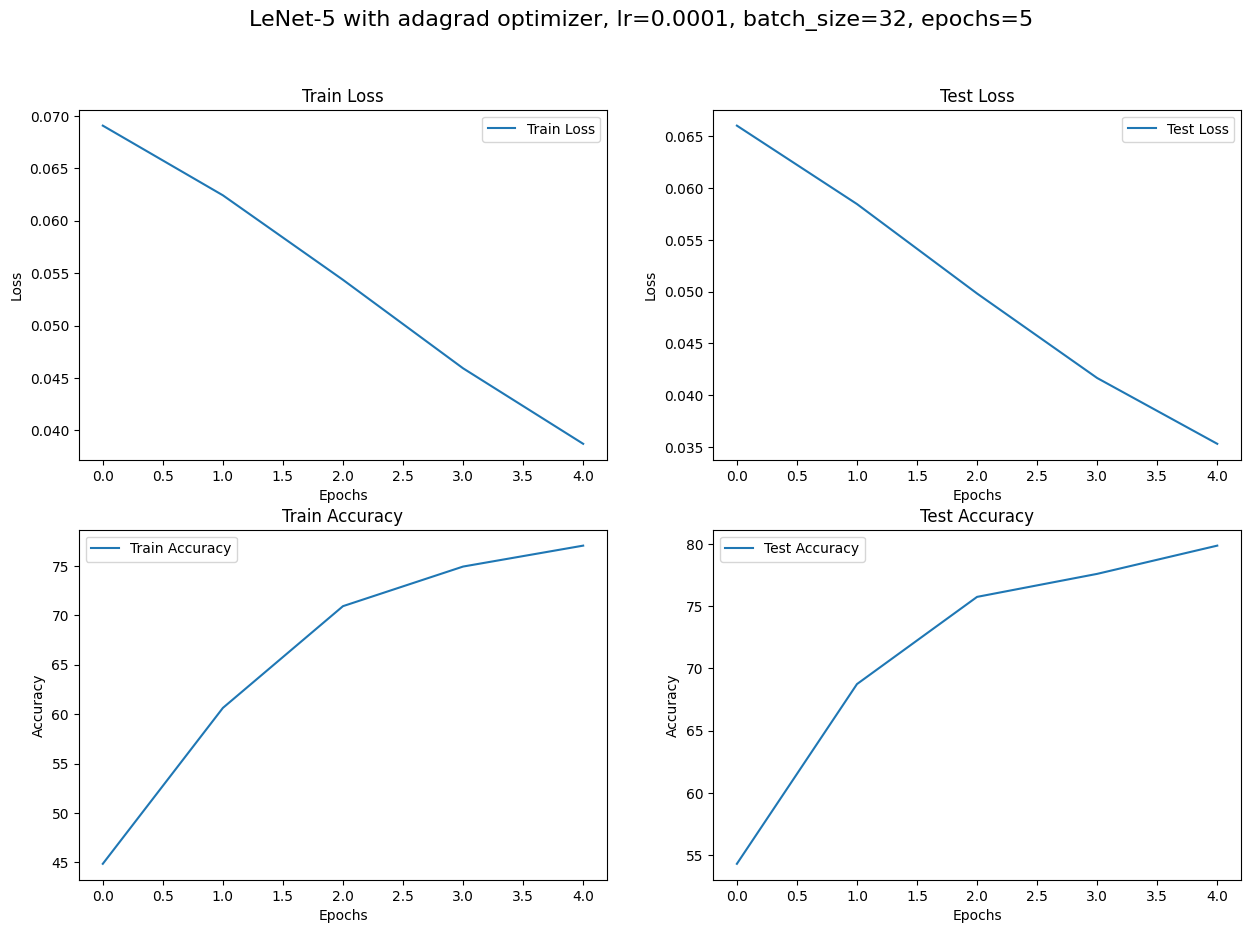

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0103 	 Accuracy: 49355/60000 (82%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 9434/10000 (94%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0026 	 Accuracy: 56959/60000 (95%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 9618/10000 (96%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0019 	 Accuracy: 57709/60000 (96%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 9693/10000 (97%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0016 	 Accuracy: 58158/60000 (97%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 9753/10000 (98%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0013 	 Accuracy: 58385/60000 (97%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 9774/10000 (98%)



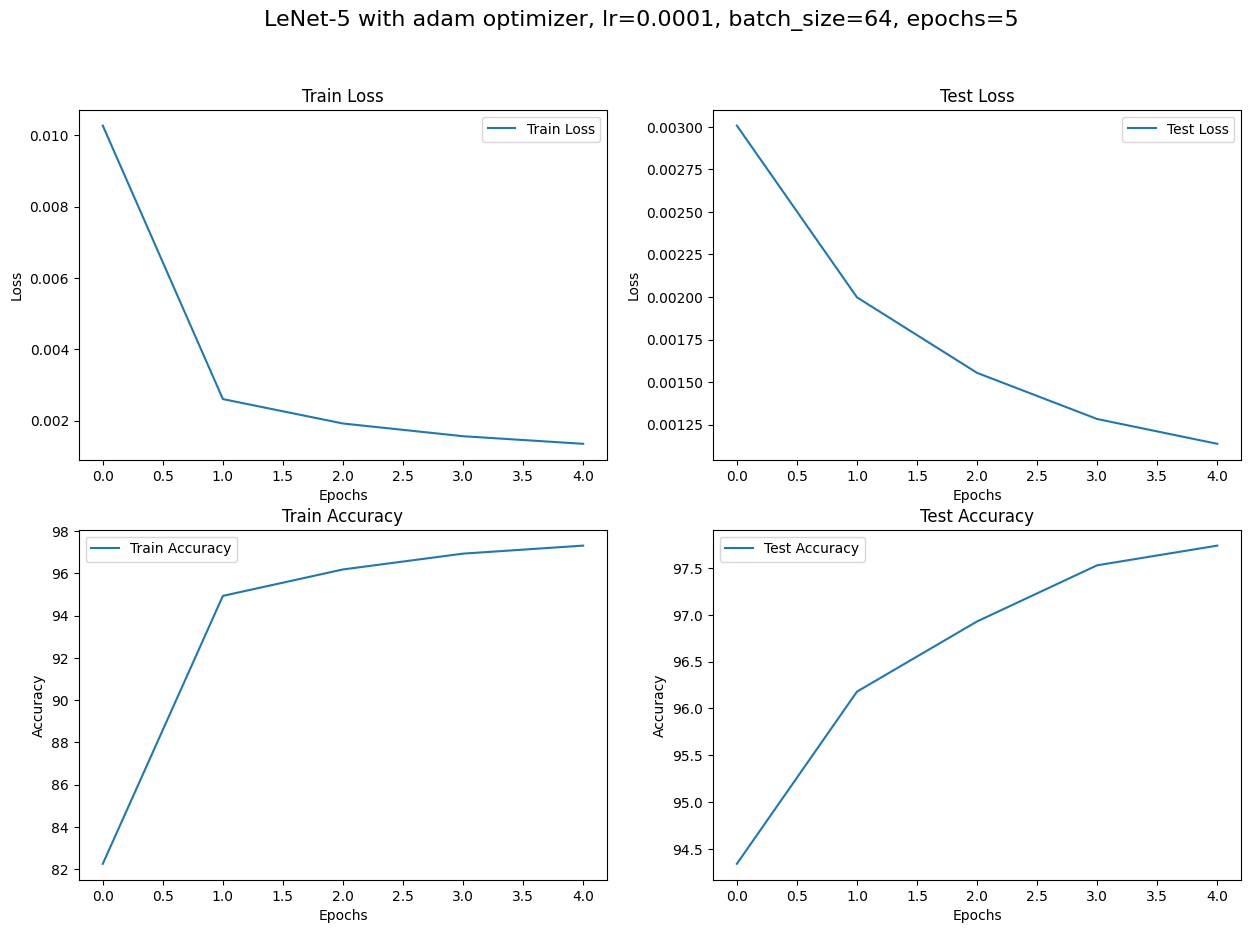

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0361 	 Accuracy: 5119/60000 (9%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 863/10000 (9%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 	 Loss: 0.0360 	 Accuracy: 5217/60000 (9%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 880/10000 (9%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 	 Loss: 0.0360 	 Accuracy: 5287/60000 (9%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 904/10000 (9%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 	 Loss: 0.0360 	 Accuracy: 5474/60000 (9%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 941/10000 (9%)



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 	 Loss: 0.0359 	 Accuracy: 5830/60000 (10%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 1029/10000 (10%)



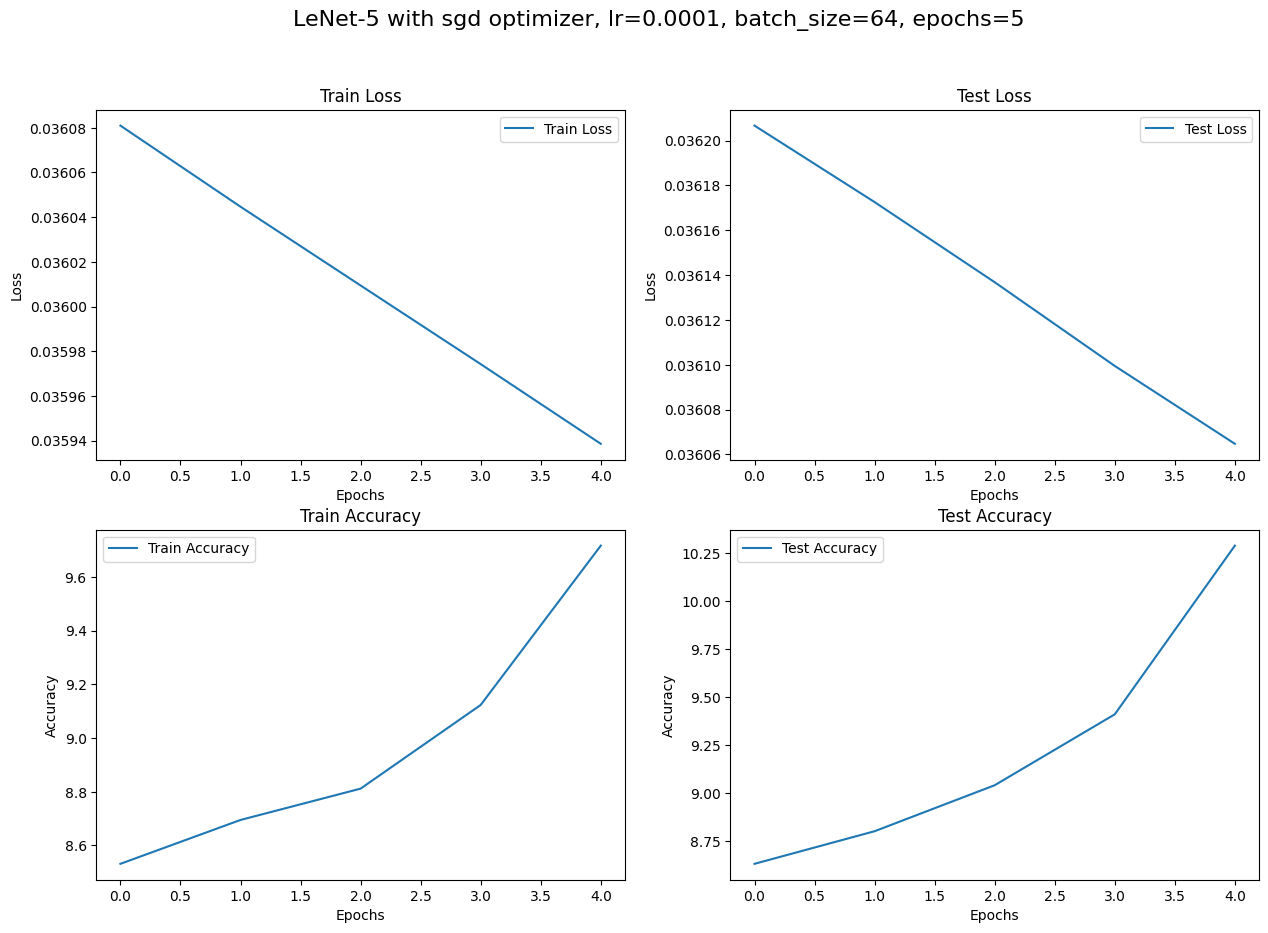

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	 Loss: 0.0081 	 Accuracy: 51700/60000 (86%)



Testing:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
epochs = [5, 10, 15, 20]
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64, 128]
optimizers = ['Adam', 'SGD', 'RMSprop', 'Adagrad']

main(epochs, learning_rates, batch_sizes, optimizers)


# Wandb Published Report

https://api.wandb.ai/links/prakhar-jain/689hnt5x

|Name                  |State   |Created                 |Runtime|Optimizer|architecture|batch_size|dataset|epochs|learning_rate|step|Epoch|Test Accuracy|Test Loss           |Train Accuracy  |Train Loss          |
|----------------------|--------|------------------------|-------|---------|------------|----------|-------|------|-------------|----|-----|-------------|--------------------|----------------|--------------------|
|wild-fog-56           |finished|2024-03-04T19:23:08.000Z|629    |rmsprop  |CNN-LeNet5  |32        |MNIST  |10    |0.0005       |    |10   |99.12        |0.00104593374561855 |99.5816666666667|0.000397415180540963|
|peachy-lake-60        |finished|2024-03-04T20:03:07.000Z|552    |rmsprop  |CNN-LeNet5  |64        |MNIST  |10    |0.0005       |    |10   |99.07        |0.000487631605299248|99.57           |0.000214323884634966|
|morning-rain-48       |finished|2024-03-04T18:07:43.000Z|560    |rmsprop  |CNN-LeNet5  |64        |MNIST  |10    |0.001        |    |10   |99.06        |0.000604097389281105|99.6716666666667|0.000161726967602605|
|confused-terrain-52   |finished|2024-03-04T18:44:13.000Z|520    |rmsprop  |CNN-LeNet5  |128       |MNIST  |10    |0.001        |    |10   |99.04        |0.000218848356368108|99.6033333333333|9.15330172380588E-05|
|happy-jazz-50         |finished|2024-03-04T18:26:34.000Z|524    |adam     |CNN-LeNet5  |128       |MNIST  |10    |0.001        |    |10   |99.04        |0.000235088422735862|99.4516666666667|0.000131021352034683|
|astral-star-16        |finished|2024-03-04T15:05:42.000Z|221    |rmsprop  |CNN-LeNet5  |128       |MNIST  |5     |0.001        |    |5    |99.03        |0.00025219831187278 |99.1216666666667|0.000220280657619878|
|fast-cloud-6          |finished|2024-03-04T14:27:23.000Z|234    |adam     |CNN-LeNet5  |32        |MNIST  |5     |0.001        |    |5    |99.02        |0.000967696615956811|99.145          |0.000891572597627965|
|zany-thunder-24       |finished|2024-03-04T15:41:51.000Z|266    |rmsprop  |CNN-LeNet5  |64        |MNIST  |5     |0.0005       |    |5    |99.01        |0.000477138536510756|99.0133333333333|0.000501983564643888|
|icy-fire-14           |finished|2024-03-04T14:58:15.000Z|216    |adam     |CNN-LeNet5  |128       |MNIST  |5     |0.001        |    |5    |99.01        |0.000244871842931025|98.8083333333333|0.000288893035236591|
|lively-shadow-12      |finished|2024-03-04T14:50:31.000Z|221    |rmsprop  |CNN-LeNet5  |64        |MNIST  |5     |0.001        |    |5    |99           |0.00048464299597108 |99.2783333333333|0.000359878073540555|
|clean-universe-20     |finished|2024-03-04T15:22:54.000Z|285    |rmsprop  |CNN-LeNet5  |32        |MNIST  |5     |0.0005       |    |5    |98.94        |0.00101363671140844 |99.2016666666667|0.00079495810988977 |
|revived-salad-54      |finished|2024-03-04T19:02:07.000Z|638    |adam     |CNN-LeNet5  |32        |MNIST  |10    |0.0005       |    |10   |98.93        |0.0012129808363733  |99.5383333333333|0.000459272144654998|
|snowy-durian-58       |finished|2024-03-04T19:44:10.000Z|570    |adam     |CNN-LeNet5  |64        |MNIST  |10    |0.0005       |    |10   |98.93        |0.000503819050059246|99.51           |0.000248661748656256|
|winter-sun-64         |finished|2024-03-04T20:40:10.000Z|534    |rmsprop  |CNN-LeNet5  |128       |MNIST  |10    |0.0005       |    |10   |98.92        |0.000250059422128834|99.3533333333333|0.000154669138291501|
|splendid-salad-42     |finished|2024-03-04T17:07:43.000Z|625    |adam     |CNN-LeNet5  |32        |MNIST  |10    |0.001        |    |10   |98.89        |0.00126661284562624 |99.4716666666667|0.000526291065923674|
|leafy-durian-44       |finished|2024-03-04T17:28:18.000Z|610    |rmsprop  |CNN-LeNet5  |32        |MNIST  |10    |0.001        |    |10   |98.86        |0.00150359095518    |99.6583333333333|0.000379403144300737|
|expert-morning-10     |finished|2024-03-04T14:42:56.000Z|218    |adam     |CNN-LeNet5  |64        |MNIST  |5     |0.001        |    |5    |98.85        |0.000579202238126891|99.0866666666667|0.000442380847472911|
|avid-totem-8          |finished|2024-03-04T14:35:05.000Z|225    |rmsprop  |CNN-LeNet5  |32        |MNIST  |5     |0.001        |    |5    |98.81        |0.00120089909445742 |99.225          |0.000784306582002773|
|divine-night-28       |finished|2024-03-04T15:59:43.000Z|254    |rmsprop  |CNN-LeNet5  |128       |MNIST  |5     |0.0005       |    |5    |98.8         |0.000282195676871925|98.7616666666667|0.000318248271930497|
|worthy-blaze-62       |finished|2024-03-04T20:22:05.000Z|541    |adam     |CNN-LeNet5  |128       |MNIST  |10    |0.0005       |    |10   |98.79        |0.000287617664551362|99.21           |0.000193075413951495|
|fragrant-feather-46   |finished|2024-03-04T17:48:49.000Z|567    |adam     |CNN-LeNet5  |64        |MNIST  |10    |0.001        |    |10   |98.79        |0.000730336817560601|99.5116666666667|0.000234377667798465|
|denim-water-18        |finished|2024-03-04T15:13:24.000Z|283    |adam     |CNN-LeNet5  |32        |MNIST  |5     |0.0005       |    |5    |98.74        |0.00111903242657718 |98.9716666666667|0.00103364110919586 |
|sandy-cherry-26       |finished|2024-03-04T15:51:05.000Z|250    |adam     |CNN-LeNet5  |128       |MNIST  |5     |0.0005       |    |5    |98.6         |0.000334793308144435|98.4683333333333|0.000388704258416935|
|neat-universe-22      |finished|2024-03-04T15:32:46.000Z|266    |adam     |CNN-LeNet5  |64        |MNIST  |5     |0.0005       |    |5    |98.52        |0.000683433342655189|98.7516666666667|0.000629491838766262|
|copper-lake-32        |finished|2024-03-04T16:19:05.000Z|319    |rmsprop  |CNN-LeNet5  |32        |MNIST  |5     |0.0001       |    |5    |98.34        |0.00162186589612393 |98.0233333333333|0.00201788385397619 |
|ruby-microwave-30     |finished|2024-03-04T16:08:30.000Z|315    |adam     |CNN-LeNet5  |32        |MNIST  |5     |0.0001       |    |5    |97.75        |0.0020916273634648  |97.6016666666667|0.0024374370993212  |
|balmy-microwave-34    |finished|2024-03-04T16:30:06.000Z|284    |adam     |CNN-LeNet5  |64        |MNIST  |5     |0.0001       |    |5    |97.74        |0.00113723151623271 |97.3083333333333|0.00134865526684249 |
|rural-brook-36        |finished|2024-03-04T16:39:45.000Z|280    |rmsprop  |CNN-LeNet5  |64        |MNIST  |5     |0.0001       |    |5    |97.26        |0.00129033358087763 |97.0866666666667|0.00150382577433872 |
|noble-galaxy-40       |finished|2024-03-04T16:58:29.000Z|270    |rmsprop  |CNN-LeNet5  |128       |MNIST  |5     |0.0001       |    |5    |96.71        |0.000809420419484377|96.5283333333333|0.000918255664501339|
|noble-sun-43          |finished|2024-03-04T17:18:16.000Z|594    |sgd      |CNN-LeNet5  |32        |MNIST  |10    |0.001        |    |10   |96.56        |0.00367651233328506 |95.84           |0.00431345461046634 |
|skilled-fog-38        |finished|2024-03-04T16:49:15.000Z|265    |adam     |CNN-LeNet5  |128       |MNIST  |5     |0.0001       |    |5    |96.42        |0.000921383780613542|95.8416666666667|0.00109313264215986 |
|vague-wildflower-45   |finished|2024-03-04T17:38:36.000Z|605    |adagrad  |CNN-LeNet5  |32        |MNIST  |10    |0.001        |    |10   |95.83        |0.00443155306708068 |95.3416666666667|0.00490458761622819 |
|dry-tree-53           |finished|2024-03-04T18:53:01.000Z|538    |adagrad  |CNN-LeNet5  |128       |MNIST  |10    |0.001        |    |10   |95.59        |0.00113244105391204 |95.0983333333333|0.00127478448674083 |
|smart-durian-49       |finished|2024-03-04T18:17:11.000Z|556    |adagrad  |CNN-LeNet5  |64        |MNIST  |10    |0.001        |    |10   |95.52        |0.00247488520666957 |95.0716666666667|0.0026856688282763  |
|silver-smoke-9        |finished|2024-03-04T14:38:58.000Z|231    |adagrad  |CNN-LeNet5  |32        |MNIST  |5     |0.001        |    |5    |95.37        |0.00482533594276756 |94.8533333333333|0.00550749535039067 |
|silvery-cloud-13      |finished|2024-03-04T14:54:19.000Z|229    |adagrad  |CNN-LeNet5  |64        |MNIST  |5     |0.001        |    |5    |93.88        |0.00317260626889765 |93.4483333333333|0.00347875862369935 |
|fresh-feather-61      |finished|2024-03-04T20:12:27.000Z|570    |adagrad  |CNN-LeNet5  |64        |MNIST  |10    |0.0005       |    |10   |93.43        |0.00361445092782378 |92.6383333333333|0.00390132008008659 |
|jolly-shape-57        |finished|2024-03-04T19:33:45.000Z|617    |adagrad  |CNN-LeNet5  |32        |MNIST  |10    |0.0005       |    |10   |93.41        |0.00682349242530763 |93.1166666666667|0.00734185062289859 |
|azure-thunder-47      |finished|2024-03-04T17:58:24.000Z|551    |sgd      |CNN-LeNet5  |64        |MNIST  |10    |0.001        |    |10   |93.4         |0.00361889123134315 |92.5733333333333|0.00394198438413441 |
|tough-smoke-7         |finished|2024-03-04T14:31:23.000Z|215    |sgd      |CNN-LeNet5  |32        |MNIST  |5     |0.001        |    |5    |93.3         |0.00710903739705682 |91.9366666666667|0.00838560646002491 |
|fast-dream-17         |finished|2024-03-04T15:09:31.000Z|225    |adagrad  |CNN-LeNet5  |128       |MNIST  |5     |0.001        |    |5    |93.16        |0.00192771521285176 |92.27           |0.00203661464117467 |
|lemon-sea-55          |finished|2024-03-04T19:12:54.000Z|606    |sgd      |CNN-LeNet5  |32        |MNIST  |10    |0.0005       |    |10   |93.12        |0.0071703332901001  |92.4483333333333|0.00801469091642648 |
|skilled-elevator-21   |finished|2024-03-04T15:27:47.000Z|291    |adagrad  |CNN-LeNet5  |32        |MNIST  |5     |0.0005       |    |5    |92.68        |0.00808641974702478 |91.83           |0.00893217890436451 |
|skilled-salad-25      |finished|2024-03-04T15:46:24.000Z|274    |adagrad  |CNN-LeNet5  |64        |MNIST  |5     |0.0005       |    |5    |92.23        |0.00418312814086676 |91.7283333333333|0.00456282431644698 |
|floral-universe-65    |finished|2024-03-04T20:49:11.000Z|528    |adagrad  |CNN-LeNet5  |128       |MNIST  |10    |0.0005       |    |10   |92.18        |0.00219291701763868 |91.5316666666667|0.00230223976249496 |
|dainty-bush-29        |finished|2024-03-04T16:04:04.000Z|259    |adagrad  |CNN-LeNet5  |128       |MNIST  |5     |0.0005       |    |5    |89.66        |0.002917635384202   |88.605          |0.00311289856930574 |
|hearty-bee-11         |finished|2024-03-04T14:46:42.000Z|221    |sgd      |CNN-LeNet5  |64        |MNIST  |5     |0.001        |    |5    |88.54        |0.00604354555904865 |86.6616666666667|0.00692234645038843 |
|icy-fire-59           |finished|2024-03-04T19:53:48.000Z|551    |sgd      |CNN-LeNet5  |64        |MNIST  |10    |0.0005       |    |10   |88.33        |0.00635887474417687 |86.9833333333333|0.00704488507931431 |
|gentle-durian-51      |finished|2024-03-04T18:35:26.000Z|520    |sgd      |CNN-LeNet5  |128       |MNIST  |10    |0.001        |    |10   |87.72        |0.00338243559598923 |86.2466666666667|0.0037199719140927  |
|noble-hill-19         |finished|2024-03-04T15:18:15.000Z|271    |sgd      |CNN-LeNet5  |32        |MNIST  |5     |0.0005       |    |5    |82.68        |0.017806163546443   |77.0783333333333|0.0263668862958749  |
|eager-glade-33        |finished|2024-03-04T16:24:33.000Z|324    |adagrad  |CNN-LeNet5  |32        |MNIST  |5     |0.0001       |    |5    |79.87        |0.0352919982731342  |77.04           |0.0387169654180606  |
|royal-fog-37          |finished|2024-03-04T16:44:33.000Z|274    |adagrad  |CNN-LeNet5  |64        |MNIST  |5     |0.0001       |    |5    |75.67        |0.0204882682800293  |73.245          |0.0221560971200466  |
|proud-disco-41        |finished|2024-03-04T17:03:07.000Z|268    |adagrad  |CNN-LeNet5  |128       |MNIST  |5     |0.0001       |    |5    |71.17        |0.0118360038638115  |68.46           |0.0123515024125576  |
|fresh-pond-23         |finished|2024-03-04T15:37:19.000Z|264    |sgd      |CNN-LeNet5  |64        |MNIST  |5     |0.0005       |    |5    |66.01        |0.0290685454964638  |52.37           |0.0319776913881302  |
|restful-frog-15       |finished|2024-03-04T15:01:59.000Z|216    |sgd      |CNN-LeNet5  |128       |MNIST  |5     |0.001        |    |5    |58.03        |0.0123960884451866  |48.0983333333333|0.0145008012036483  |
|kind-snowball-31      |finished|2024-03-04T16:13:53.000Z|304    |sgd      |CNN-LeNet5  |32        |MNIST  |5     |0.0001       |    |5    |19.93        |0.0719742784261704  |17.0483333333333|0.0718653253038724  |
|electric-armadillo-63 |finished|2024-03-04T20:31:13.000Z|529    |sgd      |CNN-LeNet5  |128       |MNIST  |10    |0.0005       |    |10   |15.85        |0.0180240051269531  |14.65           |0.0178548962513606  |
|misunderstood-shape-27|finished|2024-03-04T15:55:22.000Z|253    |sgd      |CNN-LeNet5  |128       |MNIST  |5     |0.0005       |    |5    |13.99        |0.0180526276111603  |13.9333333333333|0.0178805603702863  |
|scarlet-salad-35      |finished|2024-03-04T16:34:58.000Z|279    |sgd      |CNN-LeNet5  |64        |MNIST  |5     |0.0001       |    |5    |10.29        |0.0360646999835968  |9.71666666666667|0.0359385912299156  |
|curious-plant-39      |finished|2024-03-04T16:53:48.000Z|273    |sgd      |CNN-LeNet5  |128       |MNIST  |5     |0.0001       |    |5    |9.96         |0.0181743048429489  |9.875           |0.0179849013090134  |


---



2. [1 point] Show the results for 6 different settings of hyperparameters. You may want to change the batch size,
learning rate, and optimizer. Explain the trends in classification accuracy that you observe. Which hyperpa-
rameters are most important?


*`Answer` : Optimizer, Batch Size and Learning Rate in their decreasing order of importance as can be seen from   `Parameter Importance Panel` in the above attached wandb report.*

---

3. [0.5 points] Compare the best performing CNN (from above) against the SIFT-BoVW-SVM approach. Explain
the differences.


*`Answer` : The best performing CNN model has `batch_size = 32`, `epochs = 10`, `learning_rate = 0.0005`, `optimizer = rmsprop`*

- **Feature Extraction**: *CNNs automatically learn hierarchical features directly from raw images, while `SIFT-BoVW-SVM` relies on manually engineered features (`SIFT`) and a quantization step (`BoVW`) to create image descriptors for SVM classification.*

- **Computational Complexity**: *`CNNs` require substantial computational resources for training but offer fast inference once trained. `SIFT-BoVW-SVM` has significant upfront computational costs and very large training times (because of `KMeans`) for feature extraction and quantization but generally involves simpler models (`SVM`) with fewer parameters.*

- **Training Process**: *`CNN` training involves multiple epochs of forward and backward passes to adjust weights, highly dependent on hyperparameters. In contrast, `SIFT-BoVW-SVM` focuses on extracting and quantizing features before training a potentially simpler `SVM` model.*

- **Application Suitability**: *`CNNs` excel in complex image classification tasks with large datasets, benefiting from deep learning advancements. `SIFT-BoVW-SVM` can be effective in scenarios where specific, interpretable features are crucial or when dealing with smaller datasets.*

---

4. [0.5 points] How does the performance change if you double the number of convolutional layers?

---

5. [0.5 points] How does the performance change as you increase the number of training samples: [0.6K, 1.8K, 6K,
18K, 60K]? Explain the trends in classification accuracy that you observe.

    `Note` 1: Make sure that all classes are represented equally within different subsets of the training sets.


---

6. [1 point] Replace the CNN model with a 2 layer TransformerEncoder. Using a ViT style prediction scheme,
evaluate classification accuracy when training with 6K and 60K images. How do the results compare against
CNNs? Explain the trends.